## Chapter 9 Linear two class classification

# 9.1  Logistic regression

In the previous Chapter we discussed the fitting of a linear model to a set of input/output points - otherwise known as *linear regression*. In general all sorts of nonlinear phenomena present themselves, and the data they generate - whose input and output share a nonlinear relationship - are poorly modeled using a linear model, thus causing linear regression to perform rather poorly. This naturally leads to the exploration of fitting *nonlinear* functions to data, referred to in general as *nonlinear regression*.

In this Section we describe a very particular form of nonlinear regression called *logistic regression* that is designed to deal with a very particular kind of dataset that is commonly dealt with in machine learning/deep learning: *two-class classification data*. This sort of data is distinguished from the sort of data we saw previously by the fact that its output values are constrained to be either one of two fixed values. As we will see, such a constraint naturally leads to the choice of a *logistic sigmoid function* as the ideal nonlinear function to fit to such data, hence the name *logistic regression*. Common examples of two class classification problems include face and general object detection, with classes consisting of with a face or object versus non-facial/object images, textual sentiment analysis where classes consist of written product reviews ascribing a positive or negative opinion, and automatic diagnosis of medical conditions where classes consist of medical data corresponding to patients who either do or do not have a specific malady.  

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 9.1.1 Notation and modeling

Two class classification is a particular instance of *regression* or *surface-fitting*, wherein the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.  The actual value of these numbers is in principle arbitrary, but particular value pairs are more helpful than others for derivation purposes (i.e., it is easier to determine a proper nonlinear function to regress on the data for particular output value pairs). We will typically use $y_{p}\in\left\{ -1,\,+1\right\}$ - that is every output takes on either the value $+1$ or $-1$. Often in the context of classification the output values $y_p$ are called *labels*, and all points sharing the same label value are referred to as a *class* of data.  Hence a dataset containing points with label values $y_{p}\in\left\{ -1,\,+1\right\}$ is said to be a dataset consisting of two classes.

The simplest shape such a dataset can take is that of a set of linearly separated adjacent 'steps', as illustrated in the figure below. Here the 'bottom' step is the region of the space containing most of the points that have label value $y_p = -1$.  The 'top step' likewise contains most of the points having label value $y_p = +1$. These steps are largely separated by a point when $N = 1$, a line when $N = 2$, and a hyperplane when $N$ is larger (the term 'hyperplane' is also used more generally to refer to a point or line as well).  

As shown in the figure, because its output takes on a discrete set of values one can view a classification dataset 'from above'.  In this 'separator' perspective we remove the vertical $y$ dimension of the data and visually represent the dataset using its input only, displaying the output values of each point by coloring its input one of two unique colors (we choose blue for points with label $y_p = -1$, and red for those having label $y_p = +1$). This separator view allows us to more easily identify the linear boundary that (mostly) separates the two classes.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_10_new.png' width="80%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> Classification from a regression/surface-fitting perspective for single-input (left panels) and two-input (right panels) toy datasets. This surface-fitting view is equivalent to the 'separator' perspective where we look at each respective dataset 'from above'.  In this perspective we can more easily identify the separating hyperplane, i.e., where the step function (shown here in yellow) transitions from its bottom to top step.  In the separator view the vertical axis (the actual $y$ value) is removed, with all points being represented by their input values only.  The label of each point is then represented by color: the points in blue denote label value $-1$ while those in red have label $+1$. </em>  </figcaption> 
</figure>

This is the simplest sort of dataset with binary output we could aim to perform regression on, as in general the boundary between the two classes of data could certainly be nonlinear. We will deal with this more general potentiality later on - when discussing neural networks, trees, and kernel-based methods - but first let us deal with the current scenario.  How can we perform regression on a dataset like the ones described in the figure above?

## 9.1.2  Trying to fit a discontinuous step function

How can we fit a regression to data that is largely distributed on two adjacent steps separated by a hyperplane? Lets look at a simple instance of such a dataset when $N = 1$ to build our intuition about what must be done in general.

Intuitively it is obvious that simply fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results - the line by itself is simply too inflexible to account for the nonlinearity present in the data.  A dataset that is roughly distributed on two steps needs to be fit with a function that matches this general shape. In other words such data needs to be fit with a *step function*.

Since the boundary between the two classes is (assumed to be) linear and the labels take on values that are either $+1$ or $-1$, ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset.  What does such a function look like?  When $N = 1$ it is simply a line $y = w_0 + x_{\,}w_1$ composed with the $\text{sign}(\cdot)$ function

\begin{equation}
\text{sign}\left(w_0 + x_{\,}w_1 \right)
\end{equation}

Remember that the $\text{sign}(\cdot)$ function is defined as $\text{sign}(\alpha) = 
\begin{cases}
+1 \,\,\,\,\,\text{if} \,\, \alpha > 0 \\
-1 \,\,\,\,\,\text{if} \,\, \alpha < 0 \\
\end{cases}$.  Note here that what happens with $\text{sign}(0)$ is - for our purposes - arbitrary (i.e., it can be set to any fixed value or left undefined as we have done).

How do we tune the parameters of the line?  We could try to take the lazy way out and *first* fit the line to the classification dataset via linear regression, then compose the line with the sign function to get a step function fit.  However this does not work well in general - as we will see even in the simple instance below.  Instead we need to tune the parameters $w_0$ and $w_1$ *after* composing the line with the sign function, or in other words we need to tune the parameters of $\text{sign}\left(w_0 + x_{\,}w_1 \right)$.

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a line first and taking the sign afterward fails to represent a two-class dataset well

In the Python cell below we load in a simple two-class dataset (top panel), fit a line to this dataset via linear regression, and then compose the fitted line with the sign function to produce a step function fit. Both the linear fit (in green) as well as its composition with the sign function (in dashed red) are shown along with the data in the bottom panel.  Of course the line itself provides a terrible representation of the nonlinear dataset. But its evaluation through sign is also quite poor for such a simple dataset, failing to properly identify two points on the top step. In the parlance of classification these types of points are referred to as *misclassified points*.

In [3]:
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1.csv')

<IPython.core.display.Javascript object>


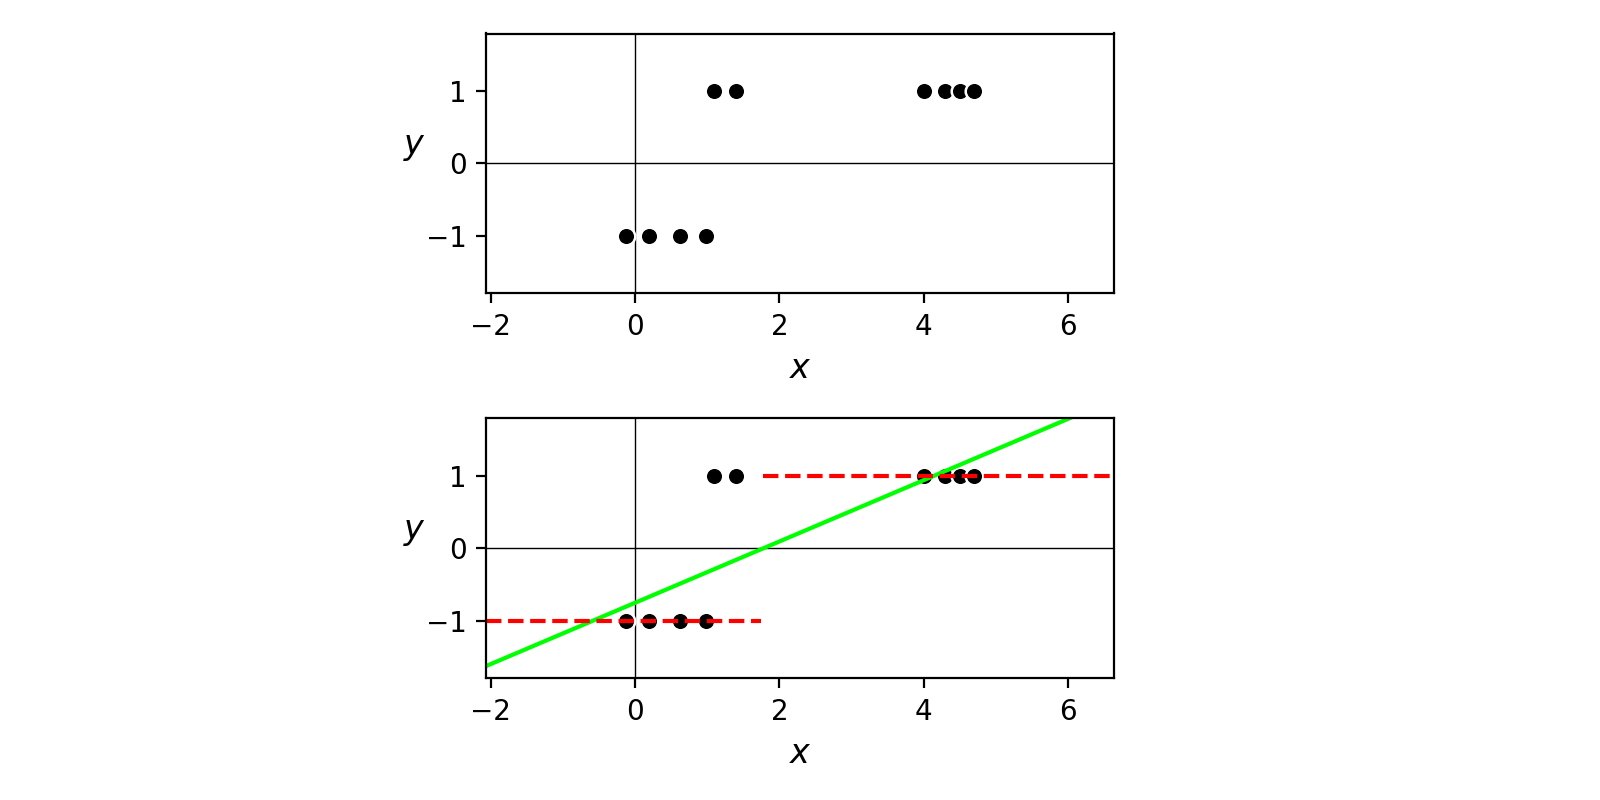

In [38]:
# create instance of linear regression demo, used below and in the next examples
demo1 = superlearn.logistic_regression_simple_demos.visualizer(data)
demo1.run_algo(algo = 'newtons_method',w_init = [-1,-1], max_its = 1)

# plot dataset
demo1.naive_fitting_demo()

----

How do we tune these parameters properly? As with linear regression, here we can try to setup a proper Least Squares function that - when minimized - recovers our ideal weights. We can do this by simply reflecting on the sort of ideal relationship we want to find between the input and output of our dataset. 

Take a single point $\left(x_p,\,y_p \right)$. Notice in the example above - and this is true more generally speaking - that ideally for a good fit we would like our weights to be such if this point has a label $+1$ it lies in the positive region of the space where $w_0 + xw_1 > 0$ so that $\text{sign}\left(w_0 + w_1x_p\right) = +1$ matches its label value.  Likewise if this point has label $-1$ we would like it to lie in the negative region where $w_0 + xw_1 < 0$ so that $\text{sign}\left(w_0 + x_pw_1\right) = -1$ matches its label value. So in short what we would ideally like for this point is that its evaluation matches its label value, i.e., that

\begin{equation}
\text{sign}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

And of course we would like this to hold for every point.  To find weights that satisfy this set of $P$ equalities as best as possible we could - as we did previously with linear regression - square the difference between both sides of each and average them, giving the Least Squares function

\begin{equation}
g(w_0,w_1) = \frac{1}{P}\sum_{p=1}^P \left(\text{sign}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

which we can try to minimize in order to recover weights that satisfy our desired equalities. If we can find a set of weights such that $g(w_0,w_1) = 0$ then all $P$ equalities above hold true, otherwise some of them do not. Notice: the evaluation of this Least Squares cost for any given $w_0$ and $w_1$ is (four times) the number of *misclassified points* for that particular choice of weights, and as a result is always integer valued. Because it counts the number of misclassifications this cost function is often referred to as the *counting cost* for two-class classification.

Unfortunately because the counting cost takes on only integer values it is impossible to minimize with our gradient-based techniques, as at every point the function is completely flat, i.e., it has exactly zero gradient. Because of this neither gradient descent nor Newton's method can take a single step 'downhill' regardless of where they are initialized. This problem is inherited from our use of the sign function, itself a discontinuous step.

#### <span style="color:#a50e3e;">Example 2: </span> Visualizing the counting cost on a simple dataset

In the next Python cell we plot the counting cost (left panel) for the dataset displayed in Example 1, over a wide range of values for $w_0$ and $w_1$.  The counting cost surface consists of discrete steps at many different levels, each one completely flat.  Because of this no local method can be used to minimize the counting cost.

In the middle and right panels we plot the surfaces of two related cost functions on the same dataset.  We introduce the cost function shown in the middle panel in the next subection, and the cost in the right panel in the one that follows.  We can indeed minimize either of these using a local method to recover ideal weights.

<IPython.core.display.Javascript object>


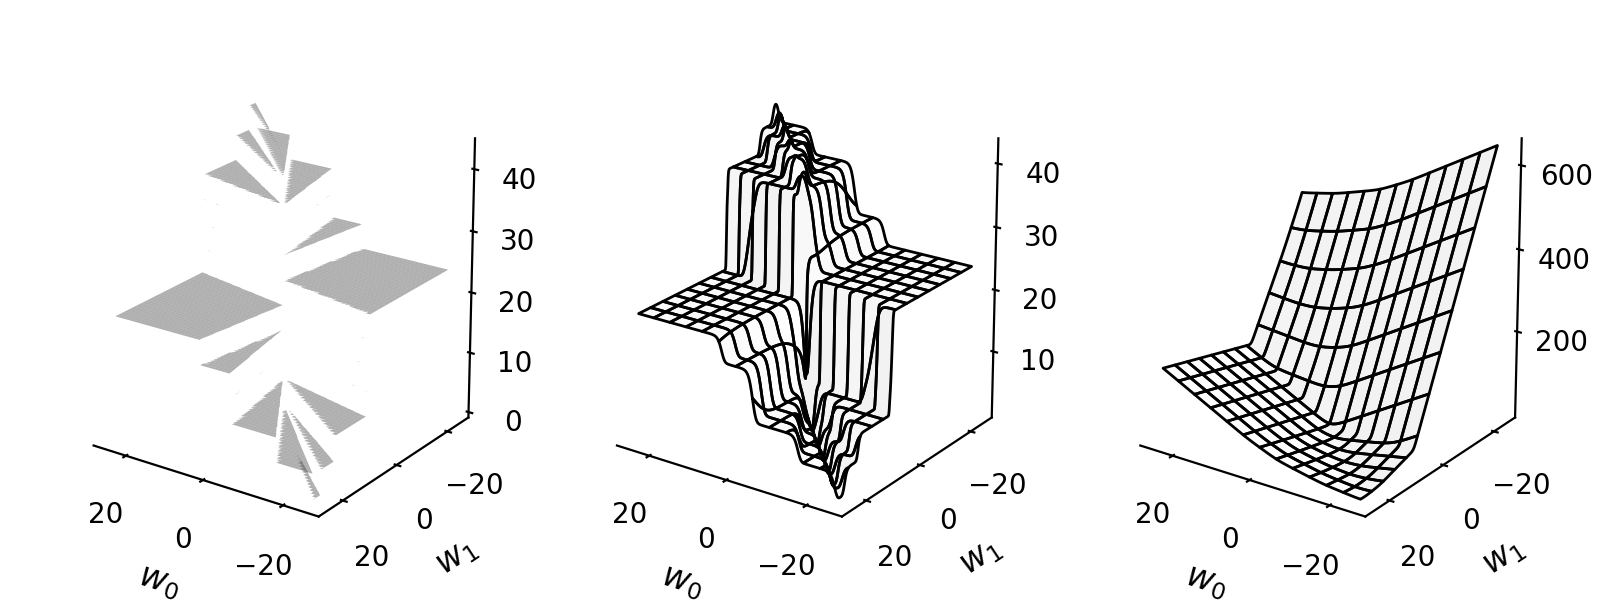

In [39]:
# create an instance of the visualizer and plot
demo2 = superlearn.cost_viewer.Visualizer(data)
demo2.plot_costs(viewmax = 25,view = [20,125])

## 9.1.2  Logistic regression

As mentioned above, we cannot directly minimize the counting cost due to our use of the sign function. In other words, we cannot directly fit a *discontinuous* step function to our data. In order to go further we need to replace the sign, ideally with a *continuous* function that matches it very closely everywhere. Thankfully such a function is readily available: the hyperbolic tangent function, $\text{tanh}(\cdot)$.  This kind of function is alternatively called a *logistic* function - and when we fit such a function to a classification dataset we are therefore performing regression with a logistic or *logistic regression*.

In the figure below we plot the tanh function (left panel), as well as several internally weighted versions of it (right panel). As we can see in the figure, for the correct setting of internal weights the hyperbolic tangent function can be made to look arbitrarily similar to the sign function.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_11_new.png' width="80%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> (left panel) Plot of the hyperbolic tangent function $\text{tanh}(x)$. (right panel) By increasing the weight $w$ in $\text{tanh}(wx)$ from $w=1$ (shown in red) to $w=2$ (shown in green) and finally to $w=10$ (shown in blue), the internally weighted version of the tanh function becomes an increasingly
good approximator of the sign function. </em>  </figcaption> 
</figure>

Swapping out the sign function with tanh in equation (2) we aim to satisfy as many of the $P$ equations

\begin{equation}
\text{tanh}\left(w_0 + x_pw_1 \right) = y_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P
\end{equation}

as possible.  To *learn* parameters that force these approximations to hold we can do precisely what we did in the case of linear regression: try to minimize the e.g., the squared error between both sides as 

\begin{equation}
\left(\text{tanh}\left(w_0 + x_pw_1 \right) - y_p \right)^2 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P.
\end{equation}

Taking the average of these squared errors gives a Least Squares cost for *logistic regression*

\begin{equation}
g\left(w_0,w_1\right) = \frac{1}{P}\sum_{p=1}^P \left(\text{tanh}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

This function - an example of which is plotted in the previous example - is generally non-convex and contains large flat regions.  Because of this - as we saw in Chapters 6 and 7 - this sort of function is not easily minimized using either gradient descent or Newtons method.  Later in Chapter 14 (in the context of deep neural networks) we will in see a how a simple adjustment to the standard gradient descent scheme can indeed minimize such functions with ease.  However - as we show below - we can actually form a different and *convex* cost function based on the set of desired approximations in equation (4).

There is more than one way to form a cost function whose minimum forces as many of the $P$ equalities in equation (4) to hold as possible. For instance, because tanh is an *odd* function - that is $\text{tanh}\left(s\right) = -\text{tanh}\left(-s\right)$ for all $s$ - and because $y_{p}\in\left\{ -1,\,+1\right\}$, equation (4) can be written, multiplying both sides by $y_p$, as 

\begin{equation}
\text{tanh}\left(y_p\left(w_0 + xw_1\right)\right) = 1
\end{equation}

Here the right hand side of the equality is one since we always have that $y_p^2 = 1$.  Now we can use the exponential definition of tanh

\begin{equation}
\text{tanh}\left(s\right) = \frac{2}{1 + e^{-s}}-1
\end{equation}

to rewrite each desired equality equivalently as 

\begin{equation}
1 + e^{-y_p\left(w_0 + xw_1\right)} = 1
\end{equation}

From here we could either subtract one off of both sides to give equivalently

\begin{equation}
e^{-y_p\left(w_0 + xw_1\right)} = 0
\end{equation}

or take the log of both sides to give

\begin{equation}
\text{log}\left(1 + e^{-y_p\left(w_0 + xw_1\right)}\right) = 0
\end{equation}

Both options provide an equivalent way of expressing the desired set of $P$ equalities implied by equation (4), both are nonnegative regardless of $p$, and both can be used to form convex cost functions for logistic regression (the former is often used in the context of *boosting*).  For example, taking the average of the $P$ latter expressions gives the commonly used *softmax* (also called the *log-loss*) cost function for logistic regression 

\begin{equation}
g\left(w_0,w_1\right) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + x_pw_1\right)}\right).
\end{equation}

The softmax cost is *always convex* regardless of the dataset used - we will see this empirically in the examples below and a mathematical proof is provided in the appendix of this Section that verifies this claim more generally (one can also compute a conservative but provably convergent steplength parameter $\alpha$ for the softmax cost based on its Lipschitz constant, which is also described in the appendix). We displayed a particular instance of the cost surface in the right panel of Example 2 for the dataset first shown in Example 1. Looking back at this surface plot we can see that it is indeed convex.

Since the softmax cost function is convex a variety of local optimization schemes can be used to properly minimize it properly.  For these reasons - as well as for the fact that a probabilistic approach for deriving logistic regression leads to a cost function equivalent to the softmax cost above as we will see later in this Section - the softmax cost is used more often in practice for logistic regression than is the logistic Least Squares cost for linear classification.

> The softmax cost is more widely used in practice for logistic regression than the logistic Least Squares cost. Being always convex we can use Newton's method to minimize the softmax cost, and we have the added confidence of knowing that local methods (gradient descent and Newton's method) are assured to converge to its global minima.

Using the same logic that led us to the softmax cost when $N = 1$, we can derive the same set of desired equalities more generally with $N>1$ inputs  

\begin{equation}
\text{log}\left( 1 + e^{-y_p\left(w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots +x_{N,p}w_{N}\right)} \right)  = 0
\end{equation}

Using our familiar compact vector notation (and - in particular - re-assigning the notation $\mathbf{x}_p$ by appending a $1$ to the top of it)

\begin{equation}
\mathbf{w}=
\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{bmatrix}
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathbf{x}_p=
\begin{bmatrix}
1\\
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix}
\end{equation}

we can write the above more compactly via the *inner product* as

\begin{equation}
\text{log}\left(1 + e^{-y_p^{\,}\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}}\right)  = 0
\end{equation}

With this we can write the softmax cost function for logistic regression for general $N$ as 

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p^{\,}\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}}\right)
\end{equation}

Both the counting cost and logistic Least Squares cost (in equations (3) and (5) respectively) can be expressed for general $N$ dimensional input using this compact notation as well. Recall, how each of these costs correspond to a different *non-linear* surface being fit to the data in the input-output space: with the counting cost it is an ideal step function, while with logistic Least Squares and softmax it is a smooth approximation to the step function. However in all cases, the classifier separating the two classes in the input space of the problem is defined by  

\begin{equation}
\mathbf{x}^T \mathbf{w}_{\,}=0
\end{equation}

which by virtue of being a hyperplane (i.e., a linear model) makes logistic regression a *linear classifier*, regardless of the cost function employed. 

> While logistic regression fits a nonlinear surface to classification data in the input-output space, the decision boundary in the input space is always linear - a hyperplane - and as a result logistic regression is considered a *linear classifier*.

#### <span style="color:#a50e3e;">Example 3: </span> Using gradient descent to perform logistic regression using the softmax cost

In this example we repeat the experiments of Example 2 using the softmax cost and gradient descent. First, we write out this cost function in ``Python`` in the next cell. Once again the translation is fairly straightforward.

In [ ]:
# take input/output pairs from data
x = data[:,0] 
y = data[:,1:] 

# tack a 1 onto the top of each input point
x = x[np.newaxis,:]; 
o = np.ones((1,np.size(x)));
x = np.concatenate((o,x),axis = 0)

In [4]:
# the convex softmax cost function
def softmax(w):
    P = len(y)
    cost = 0
    for p in range(P):
        # get pth input/output pair
        x_p = x[:,p]
        y_p = y[p]
        
        # add to current cost
        cost +=np.log(1 + np.exp(- y_p*np.dot(x_p.T,w)))
    return cost/float(P)    

With our cost function defined in ``Python`` we can now run our demonstration. We initialize at the point $w_0 = 3$ and $w_1 =3$, set $\alpha = 1$, and run for 25 steps.  

In [7]:
# run gradient descent to minimize the softmax cost
g = softmax; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

Each step of the run is now animated - along with its corresponding fit to the data.  In the left panel both the data and the fit at each step (colored green to red as the run continues) are shown, while in the right panel the contour of the cost function is shown with each step marked (again colored green to red as the run continues).  Moving the slider from left to right animates the run from start to finish. Note how we still have some zig-zagging behavior here, but since we can safely use unnormalized gradient descent, its oscillations rapidly decrease in magnitude since the length of each step is directly controlled by the magnitude of the gradient.


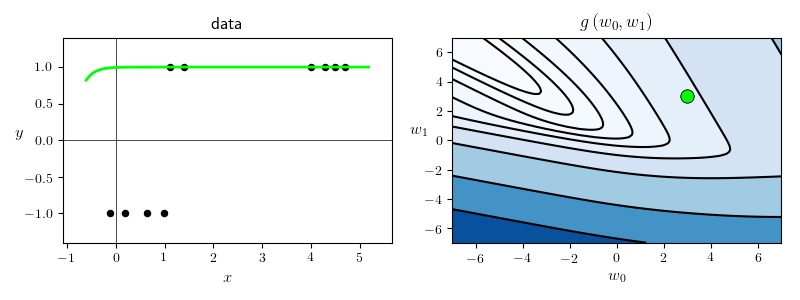
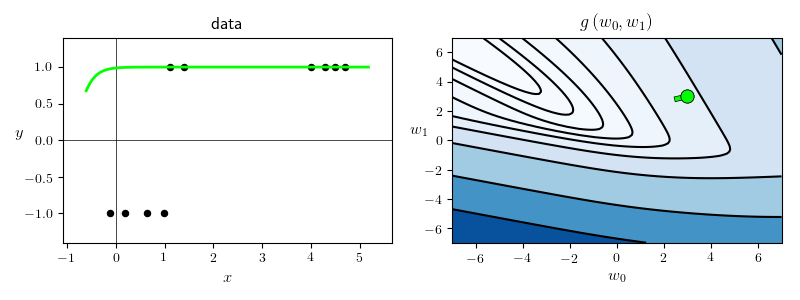
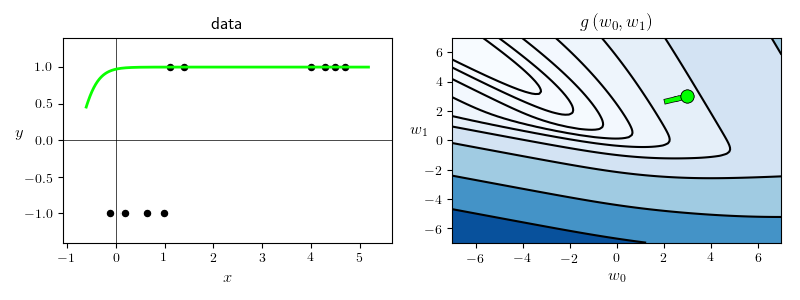
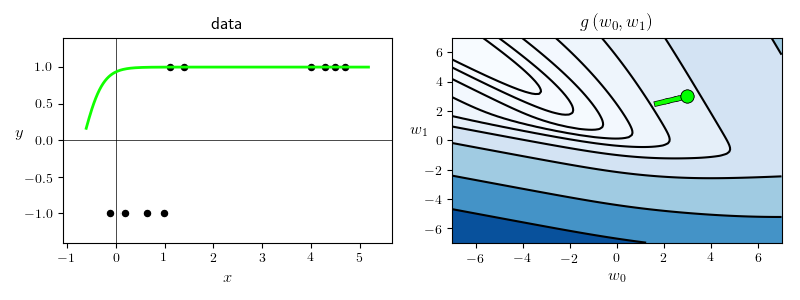
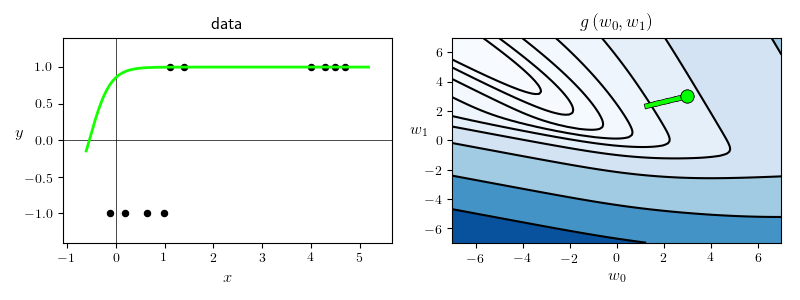
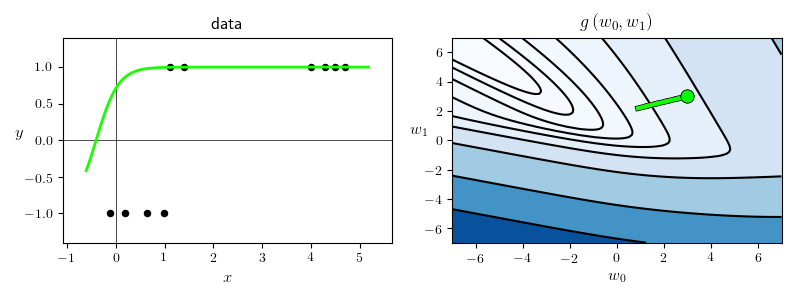
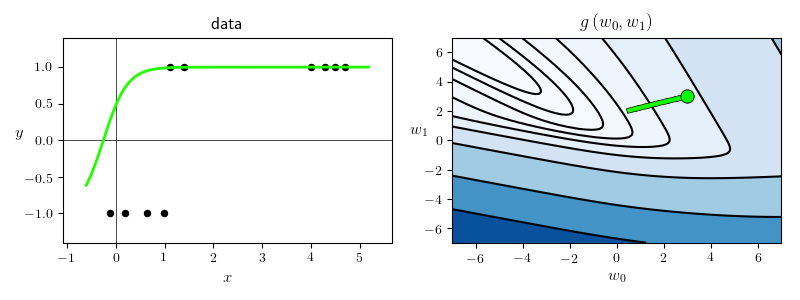
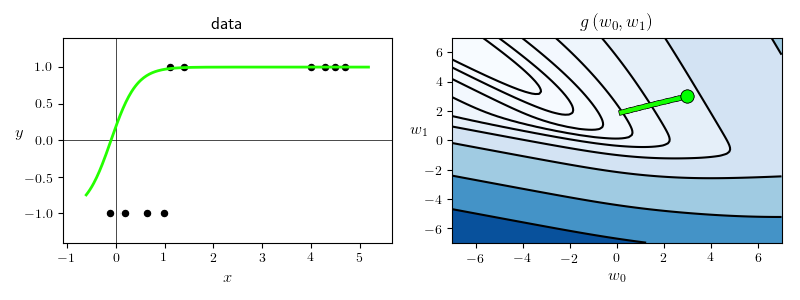
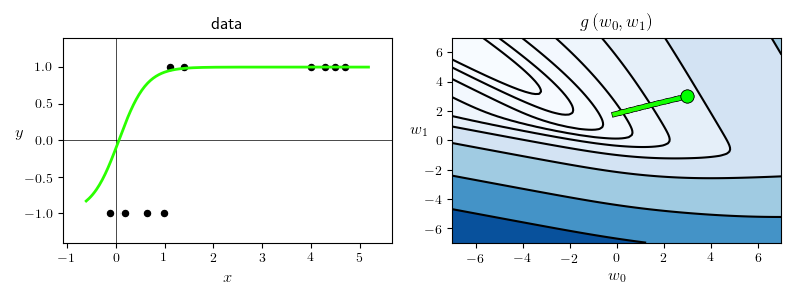
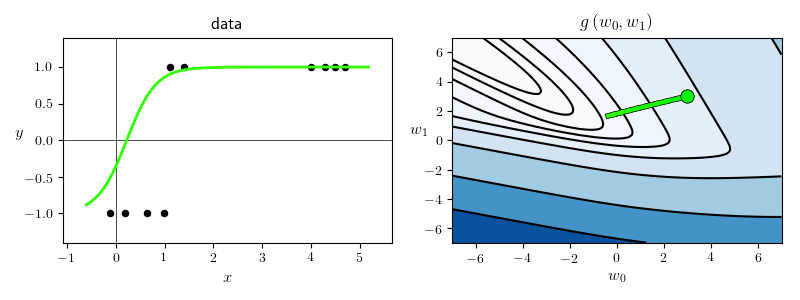
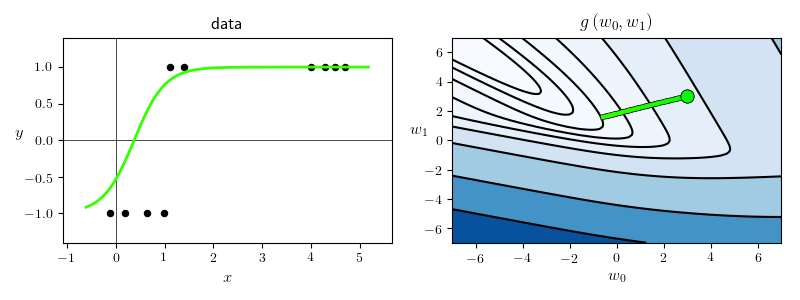
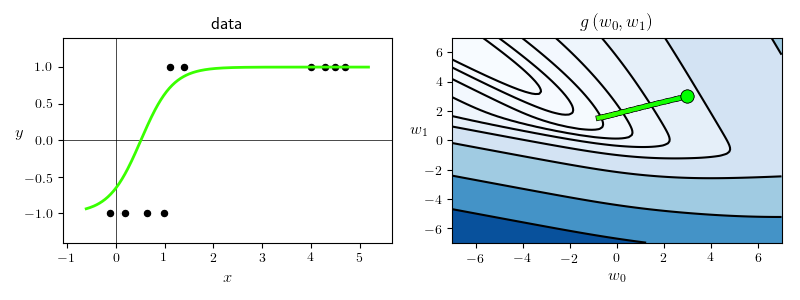
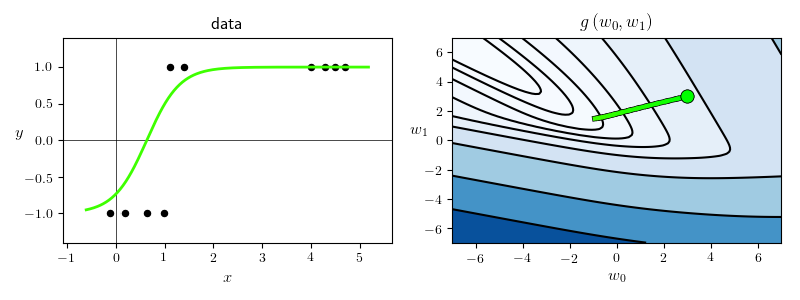
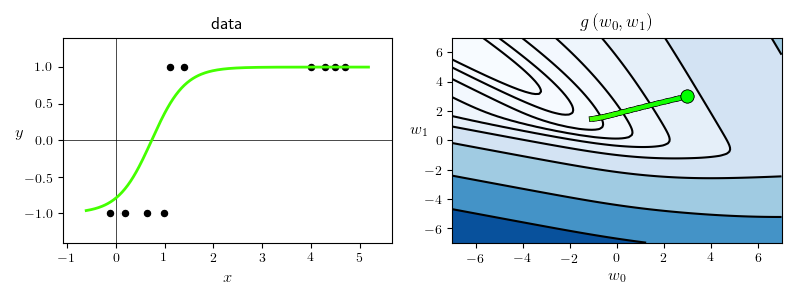
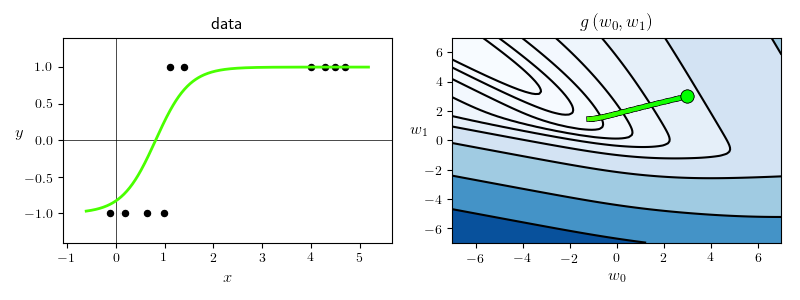
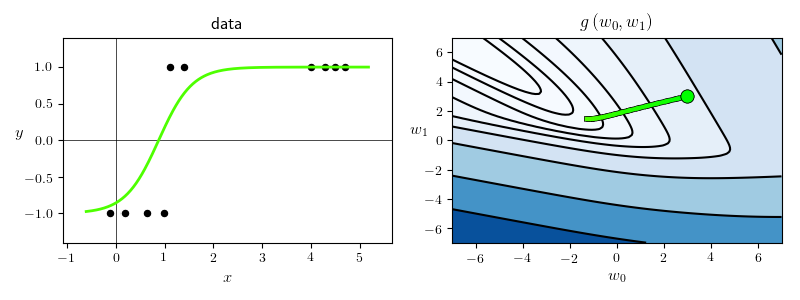
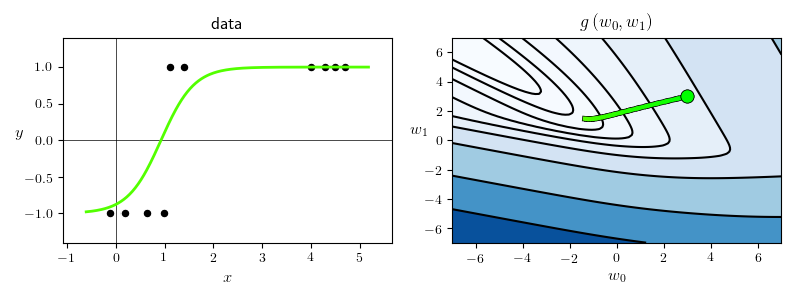
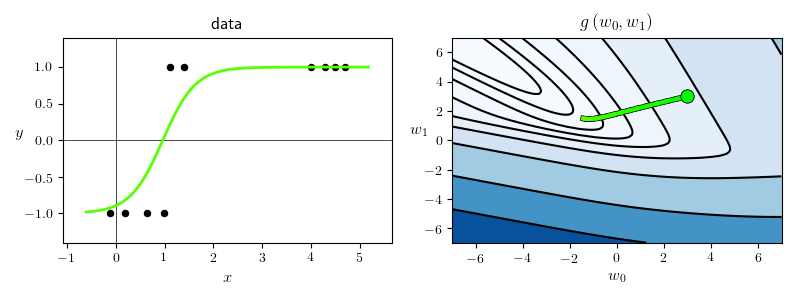
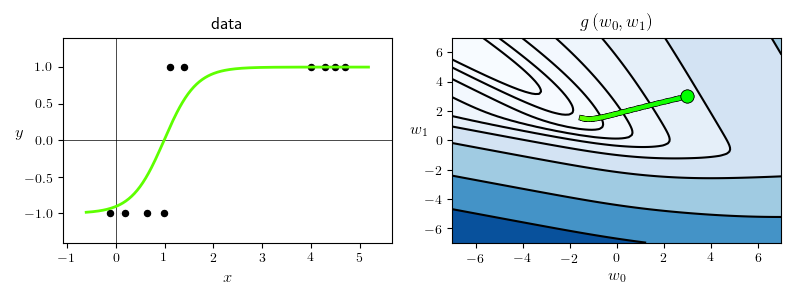
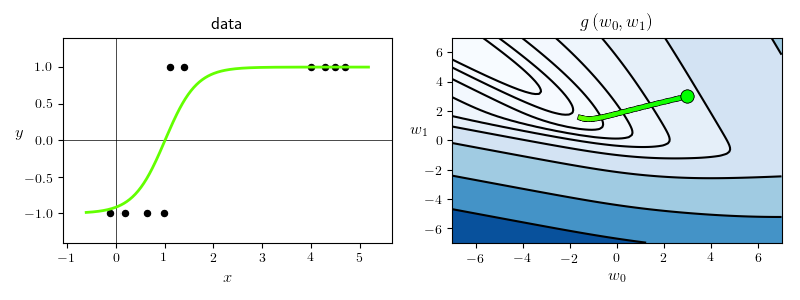
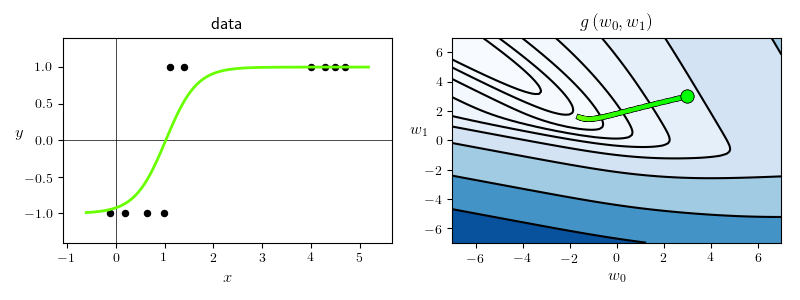
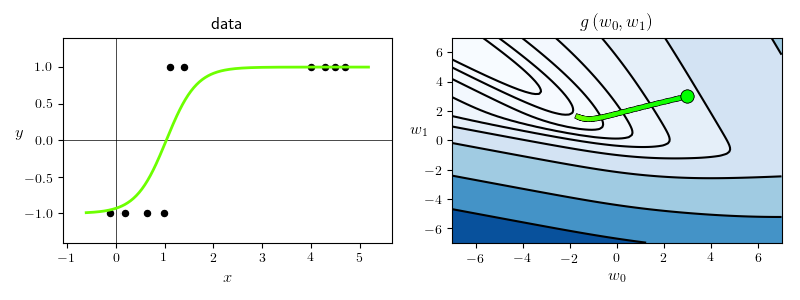
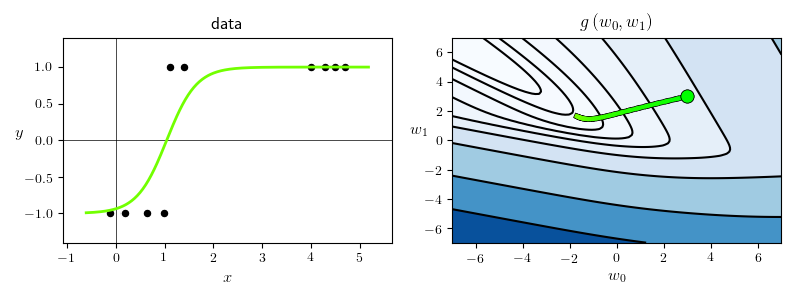
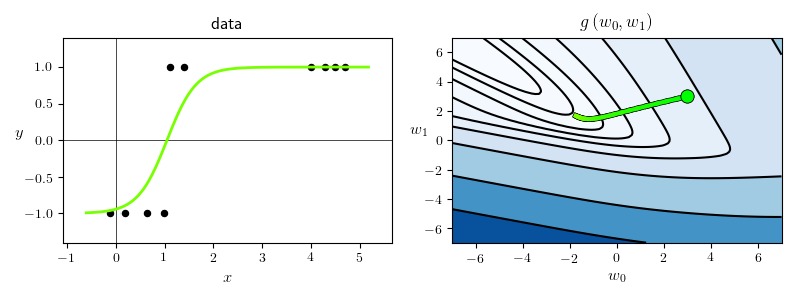
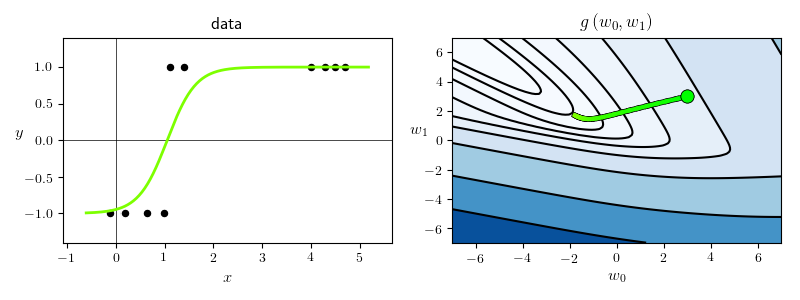
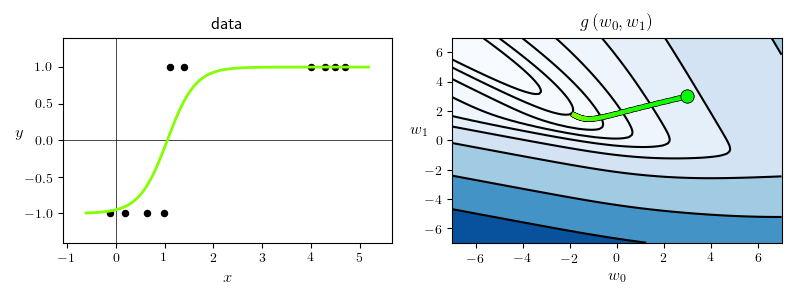
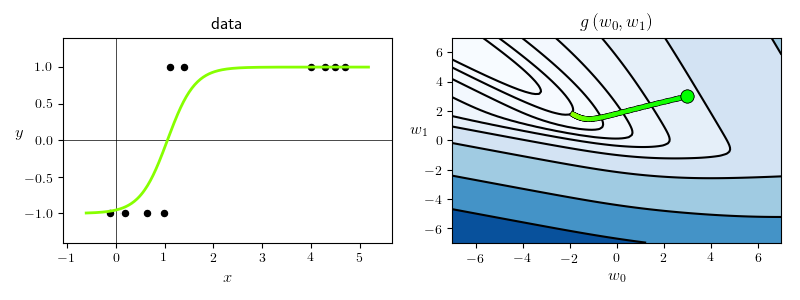
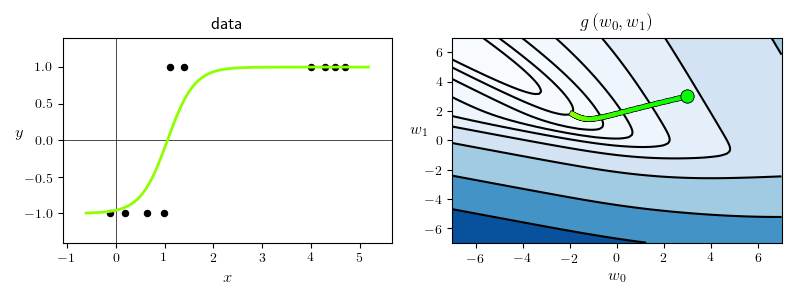
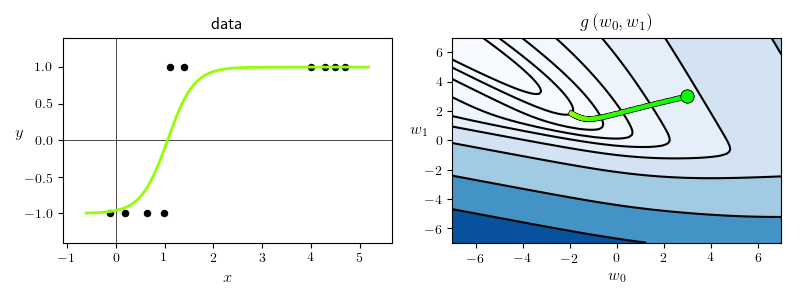
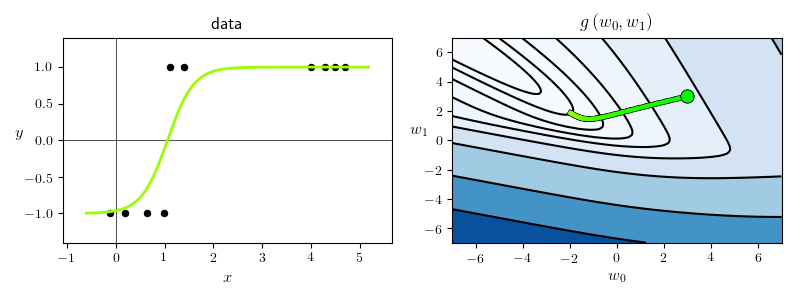
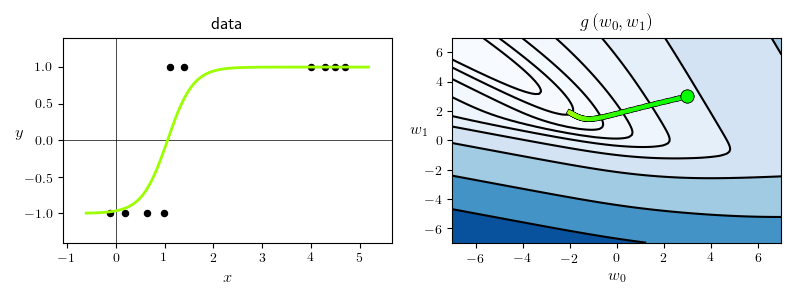
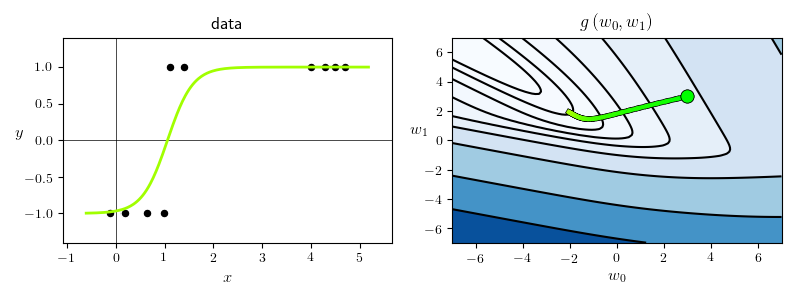
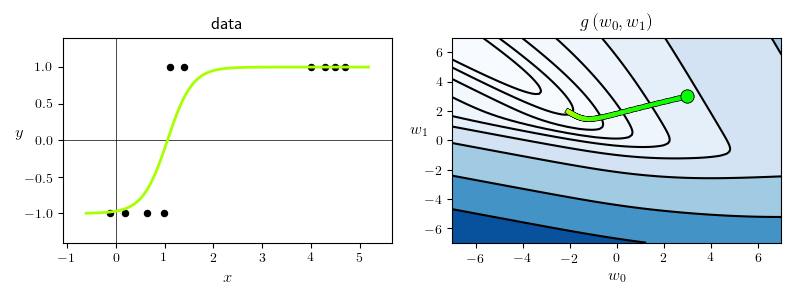
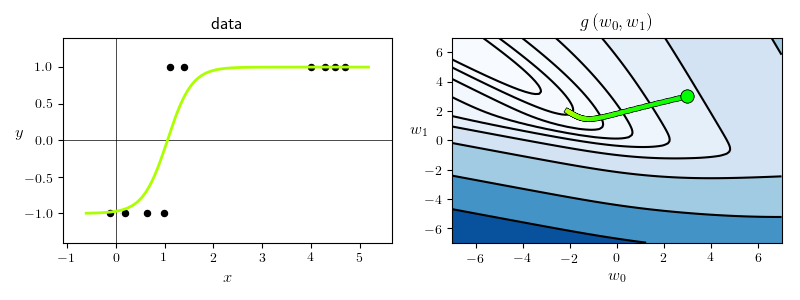
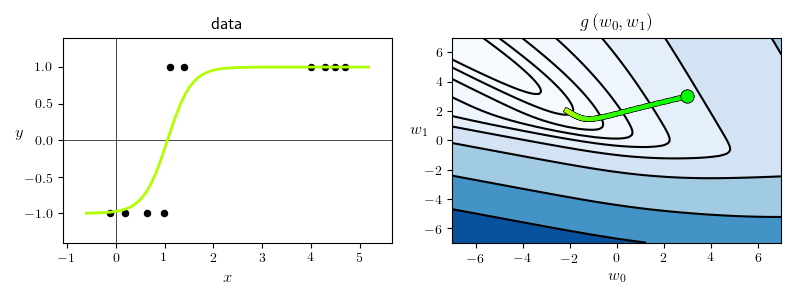
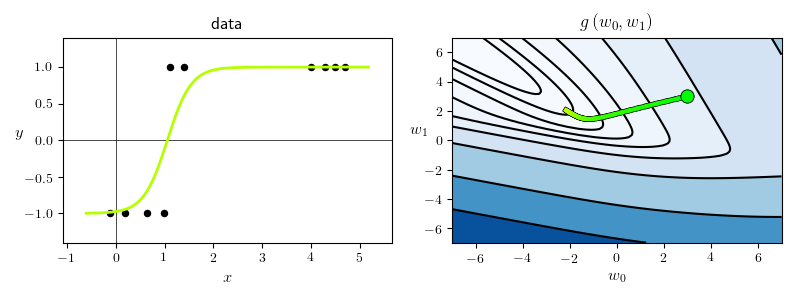
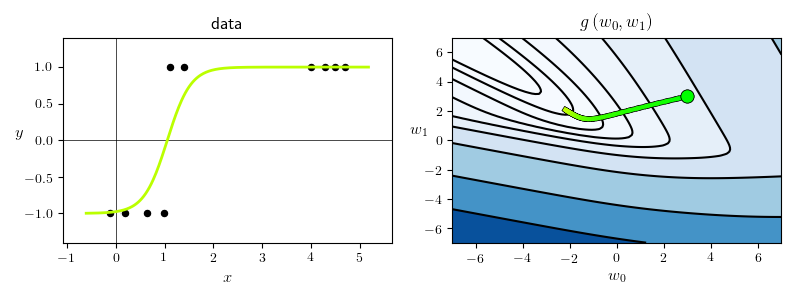
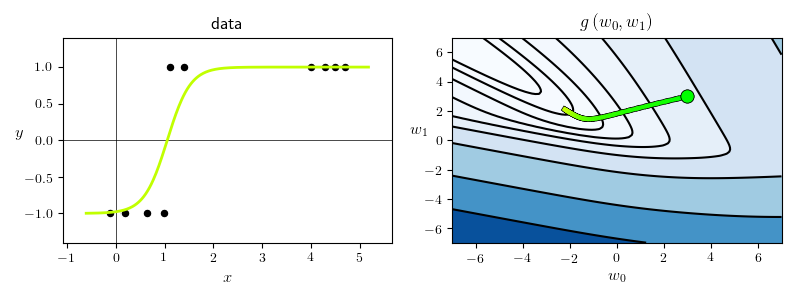
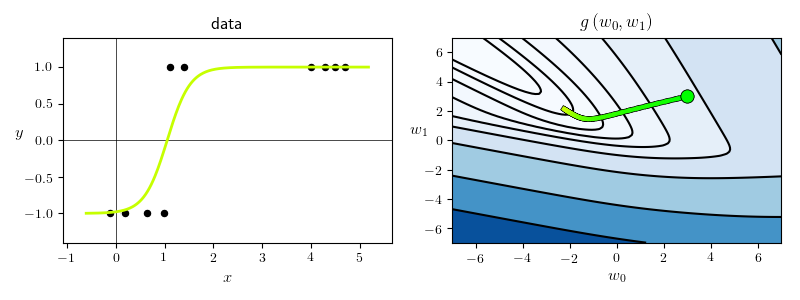
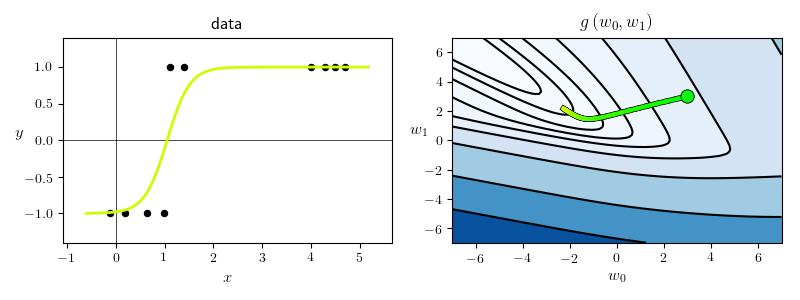
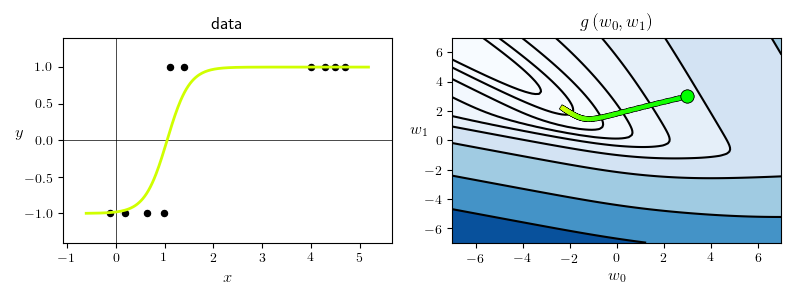
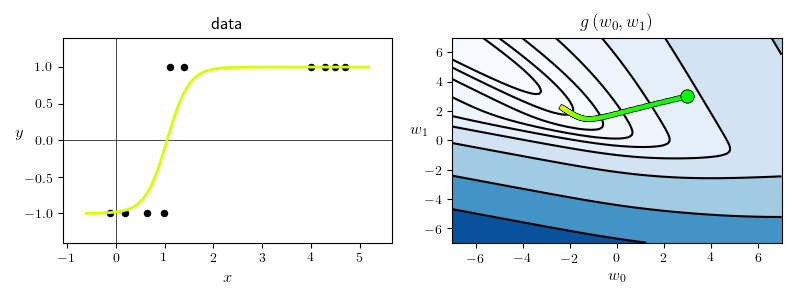
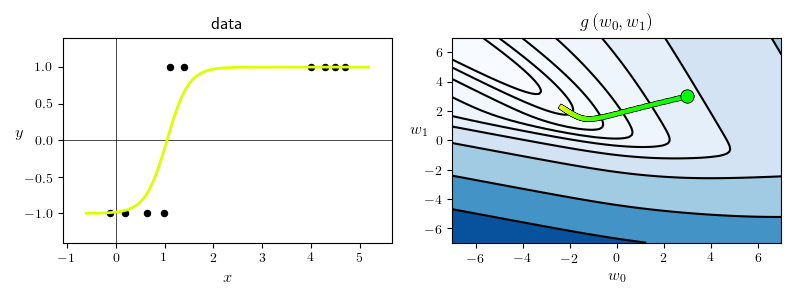
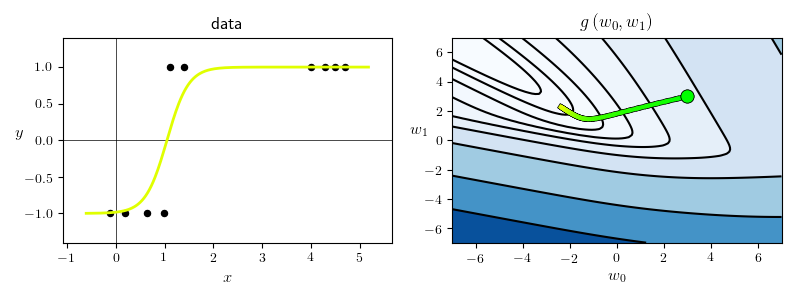
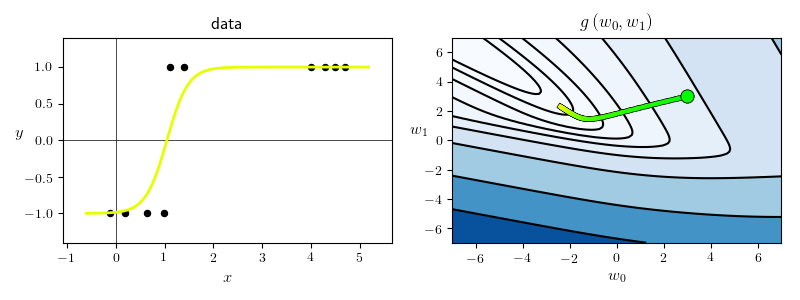
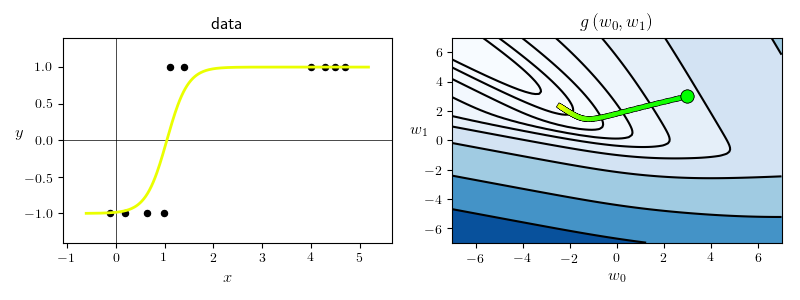
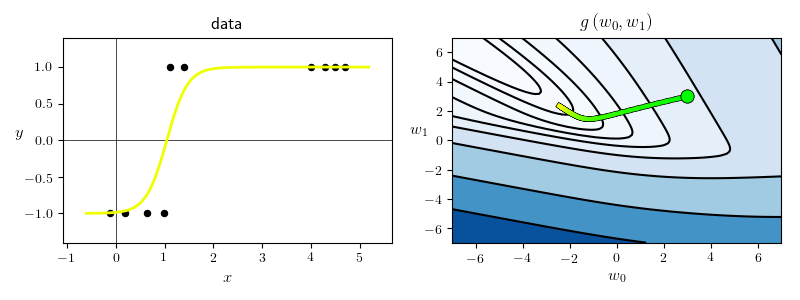
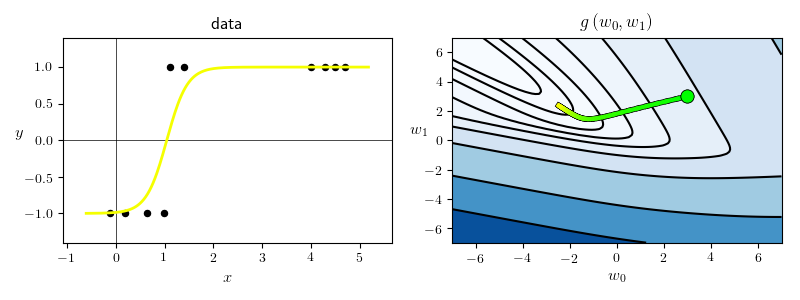
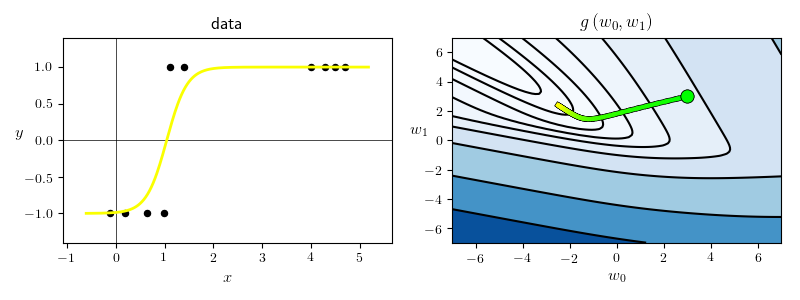
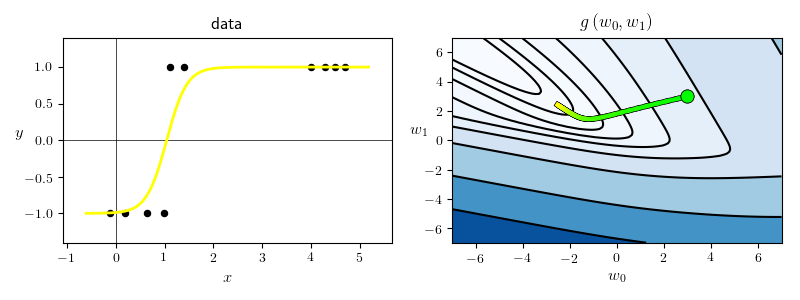
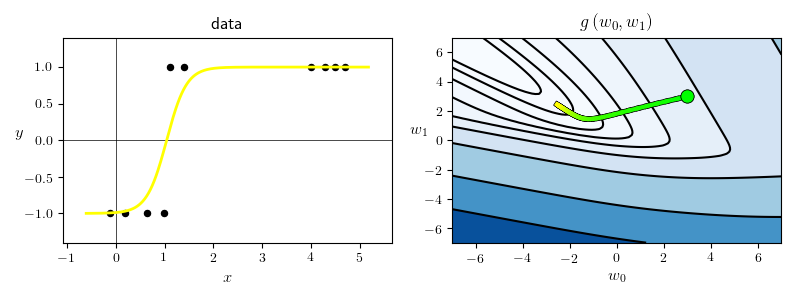
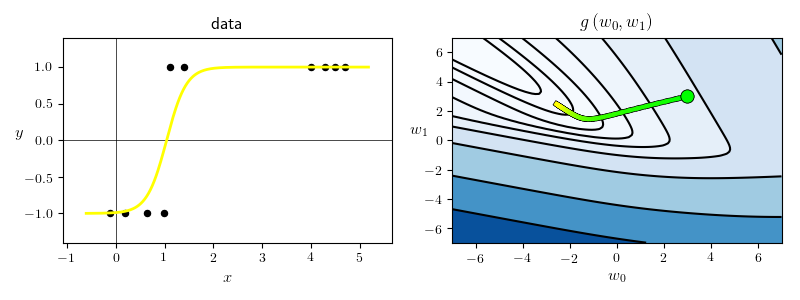
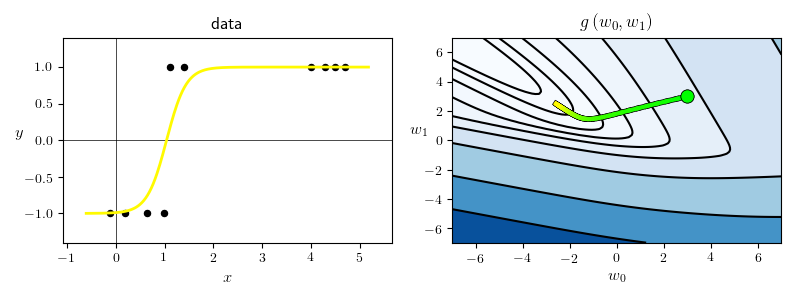
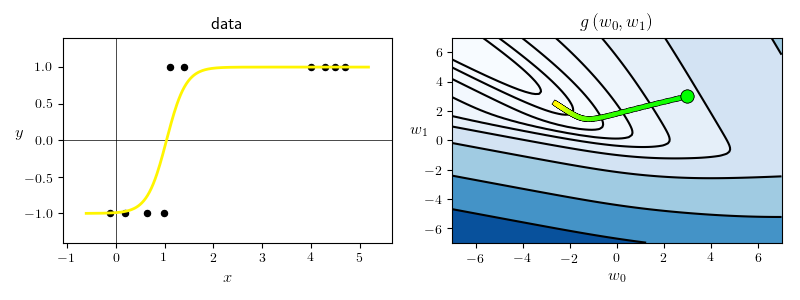
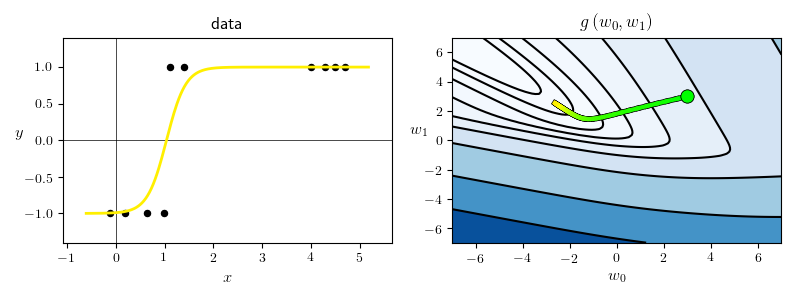
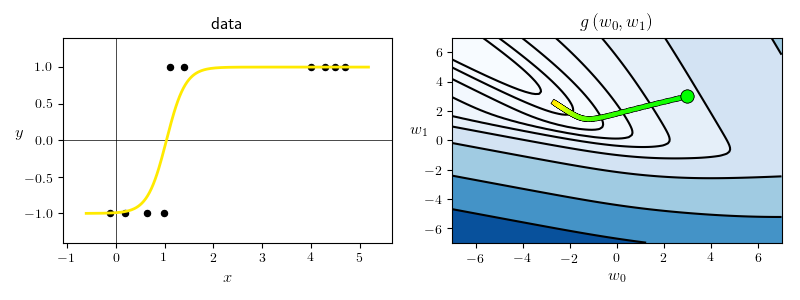
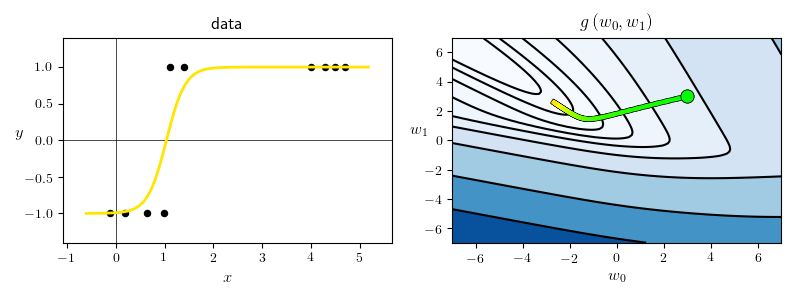
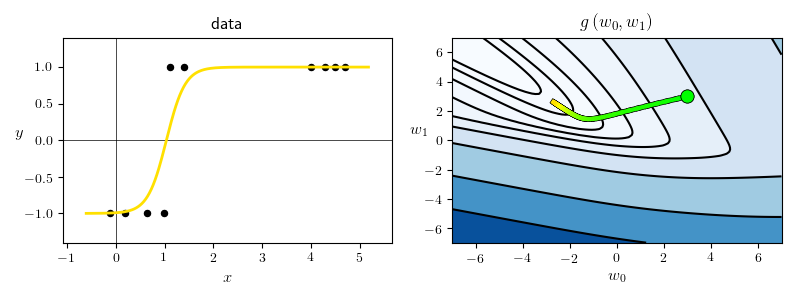
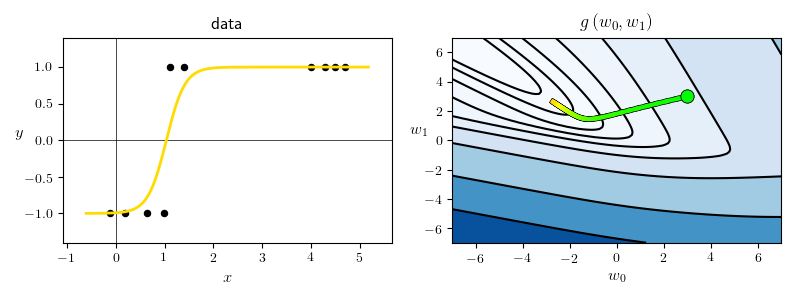
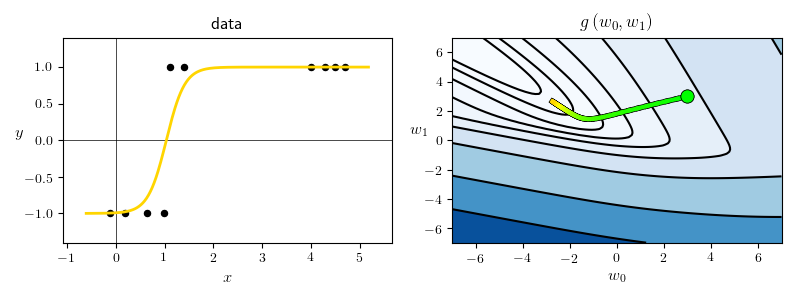
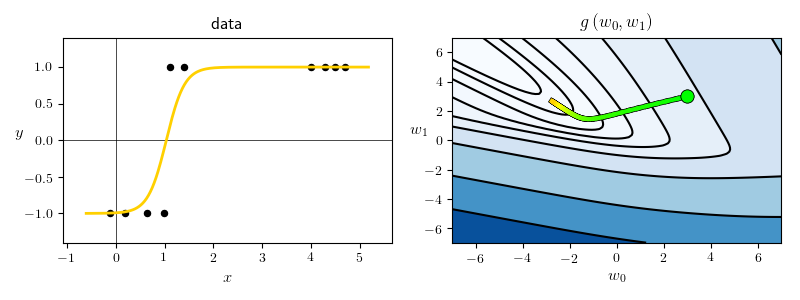
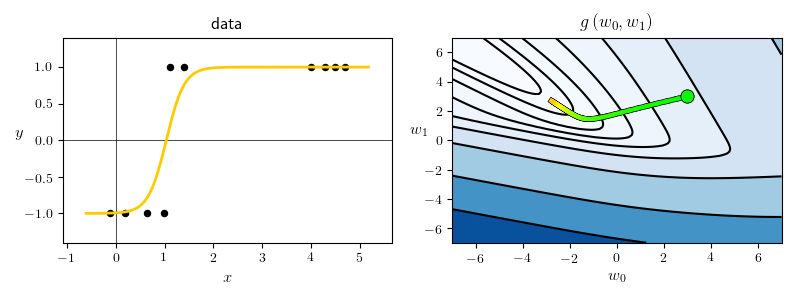
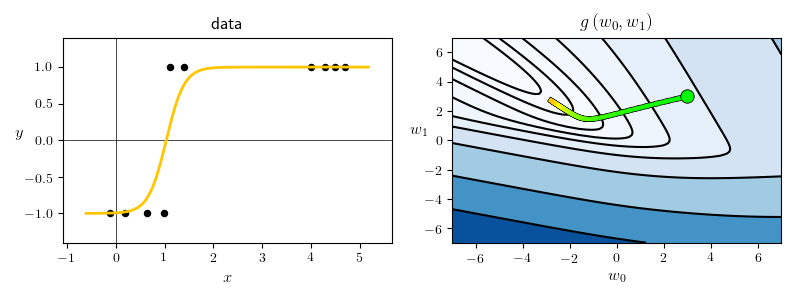
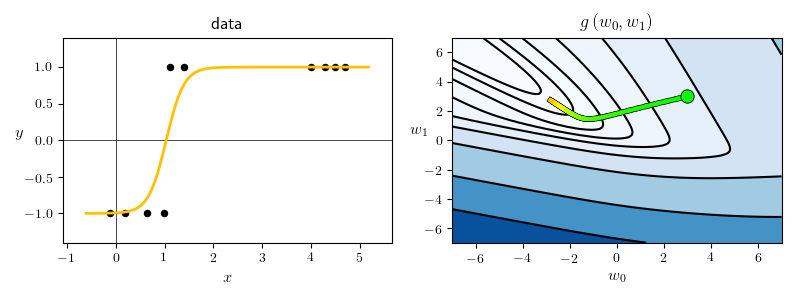
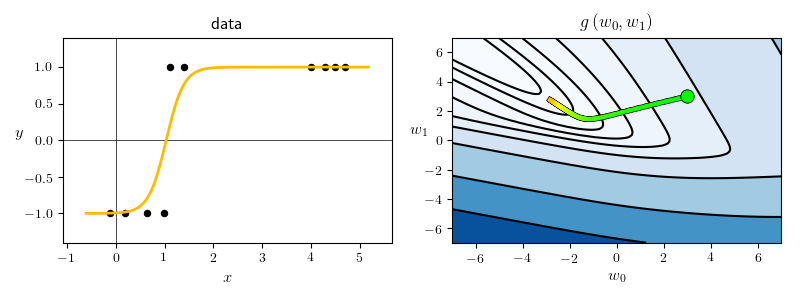
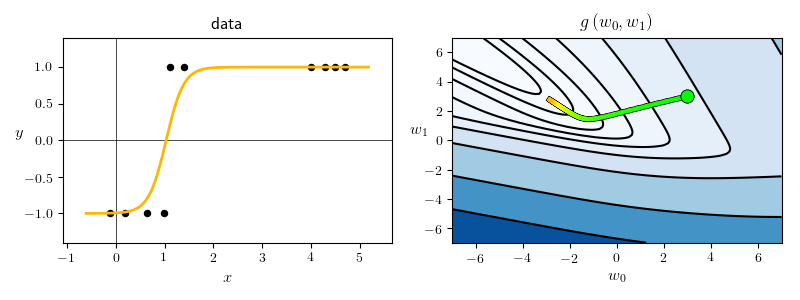
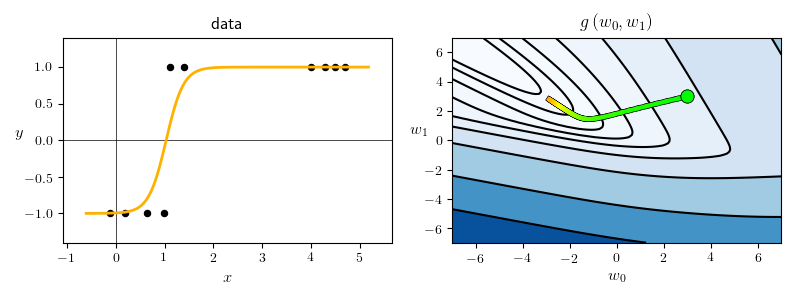
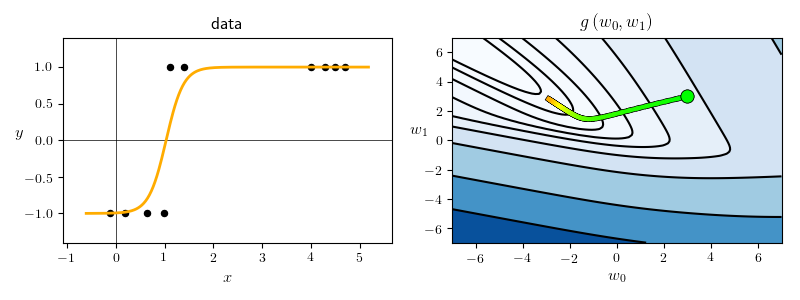
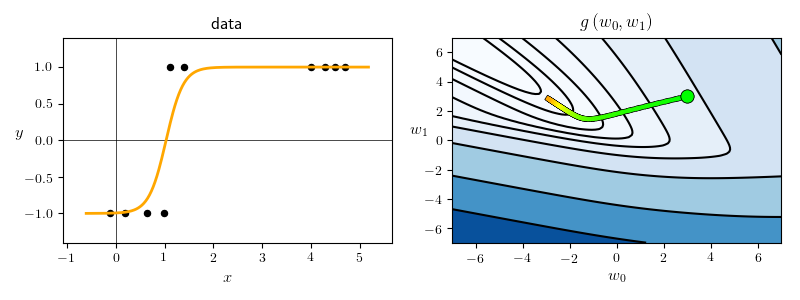
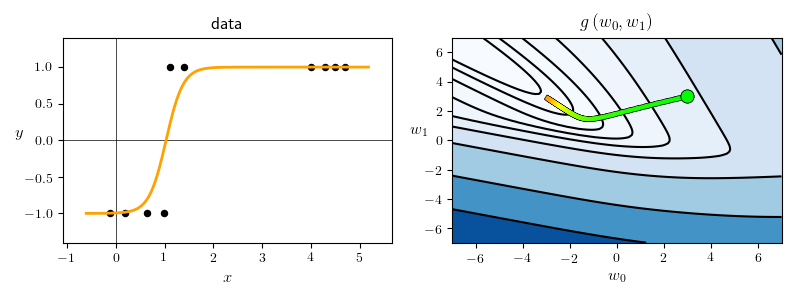
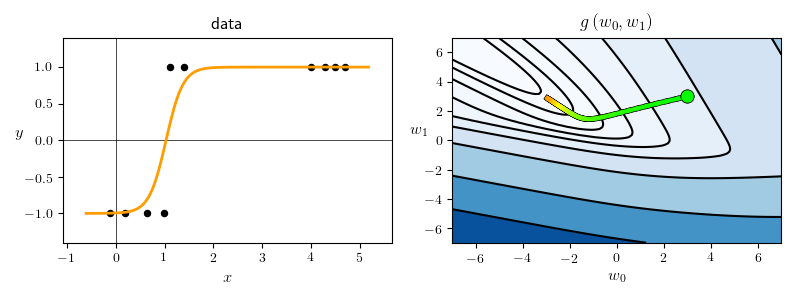
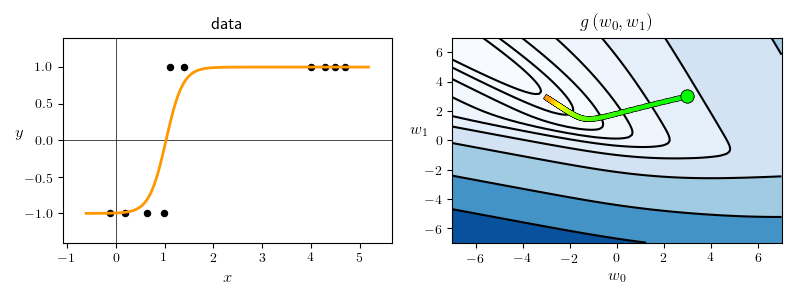
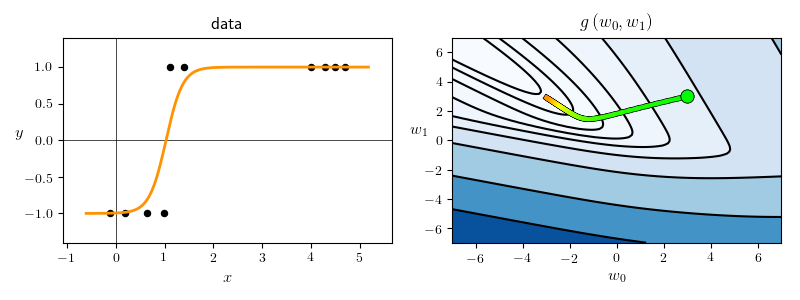
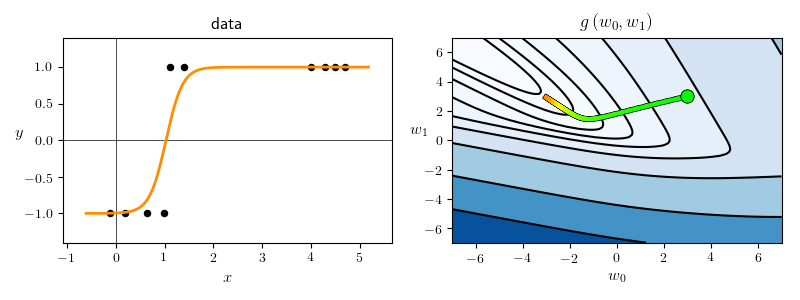
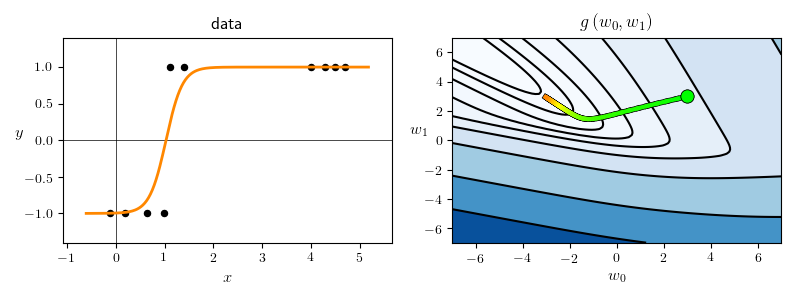
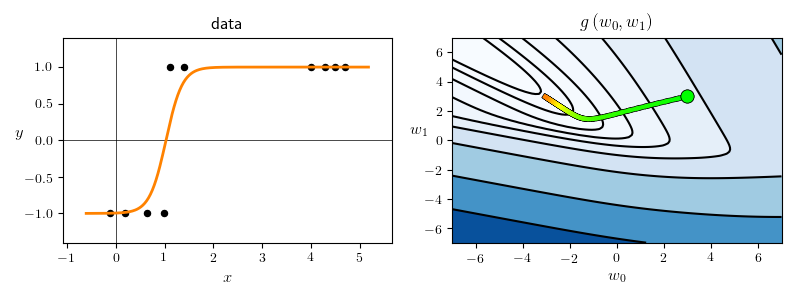
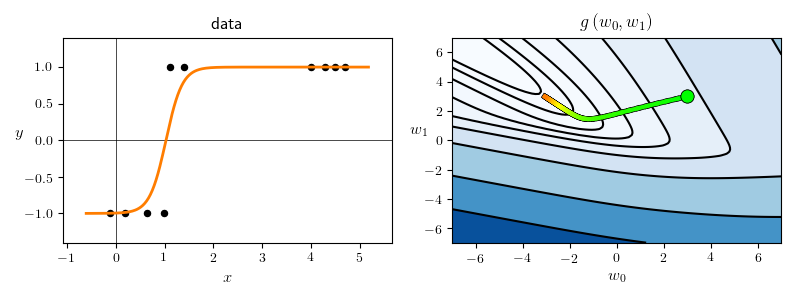
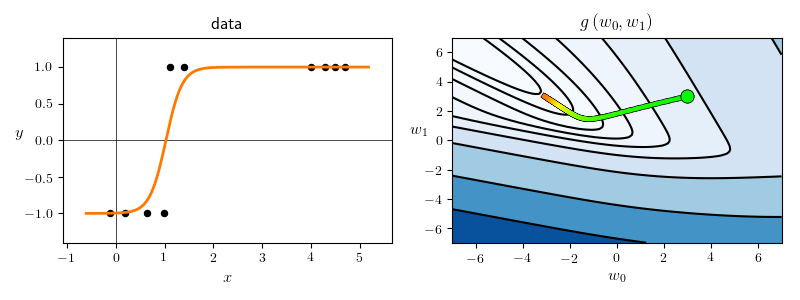
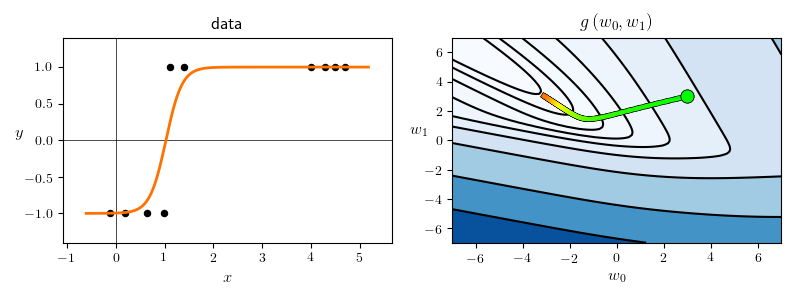
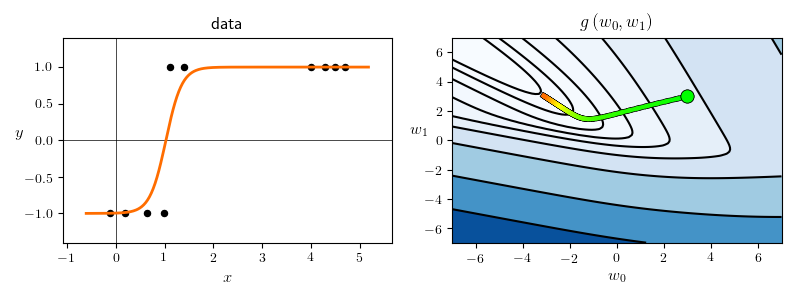
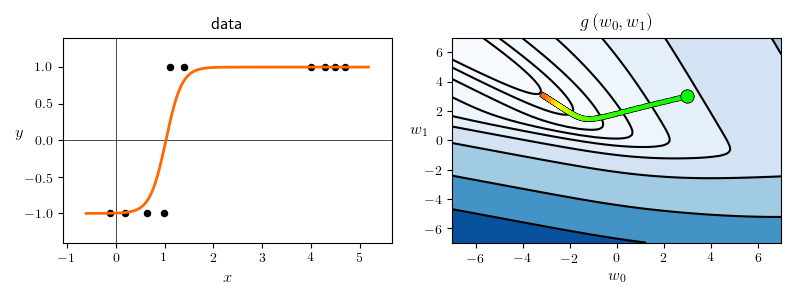
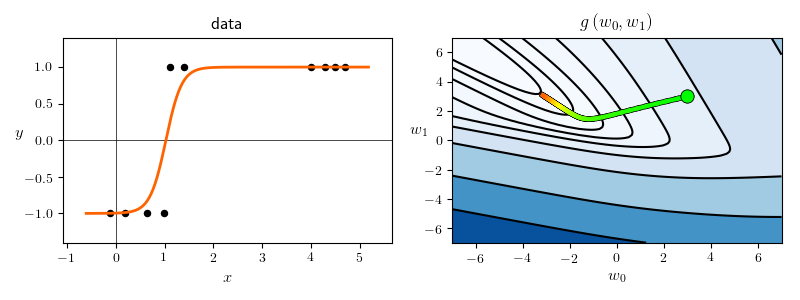
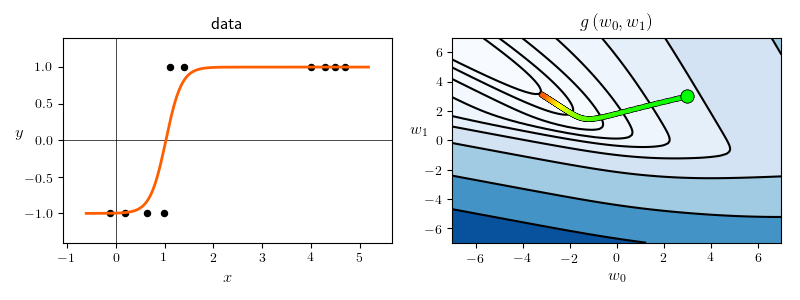
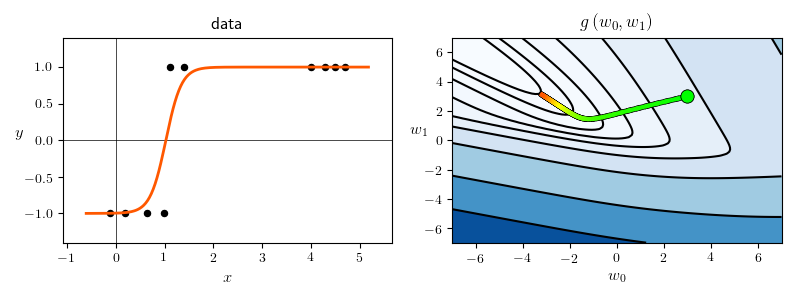
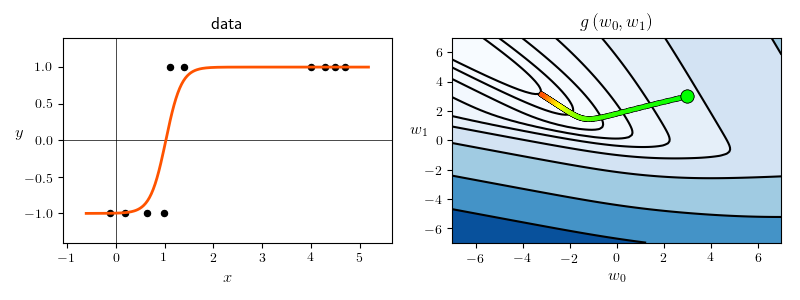
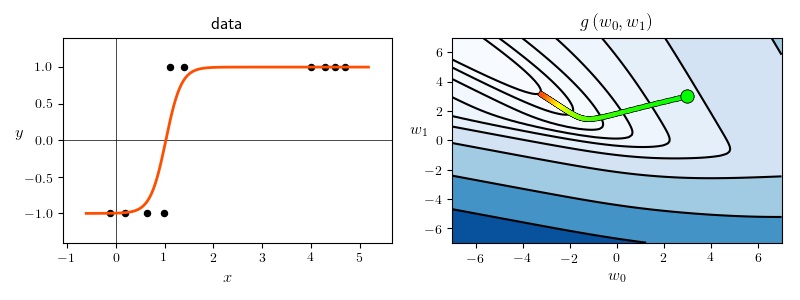
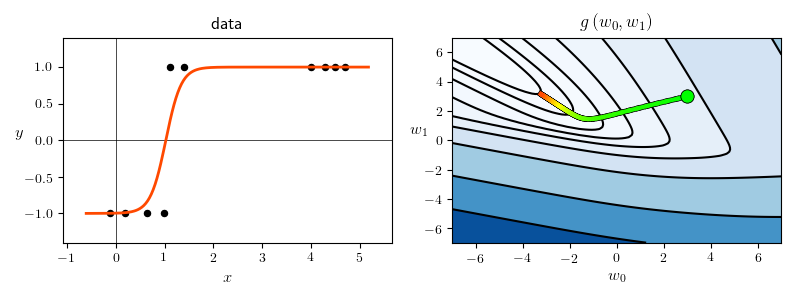
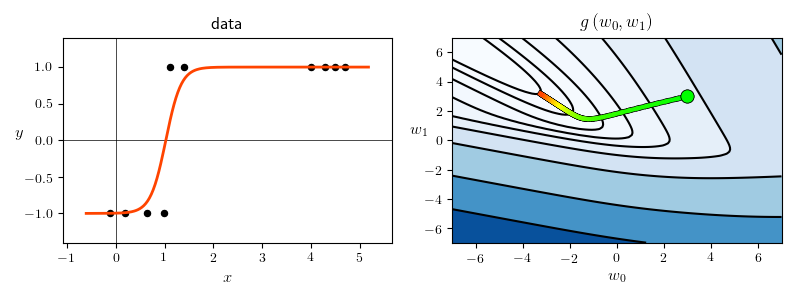
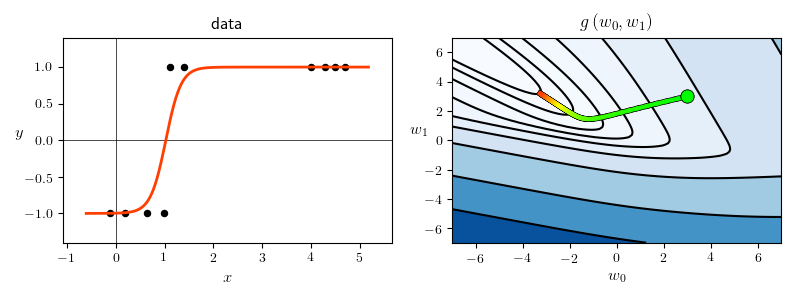
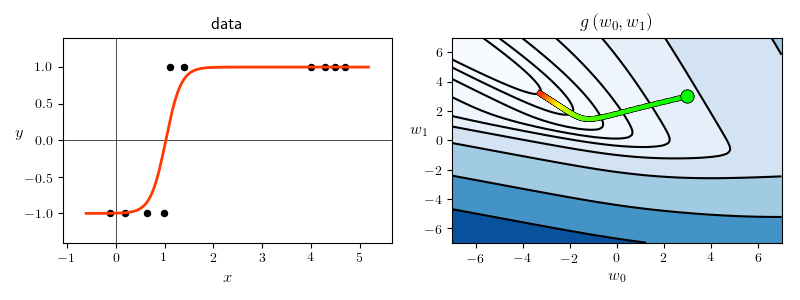
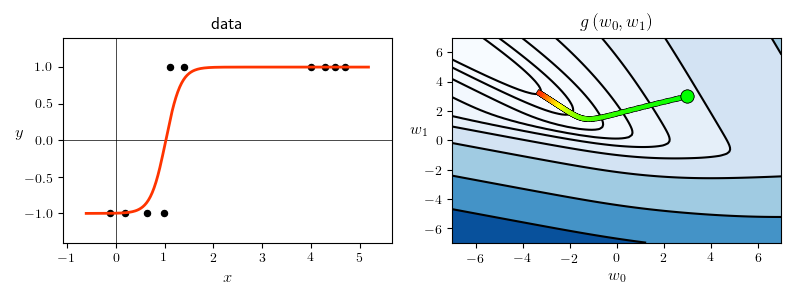
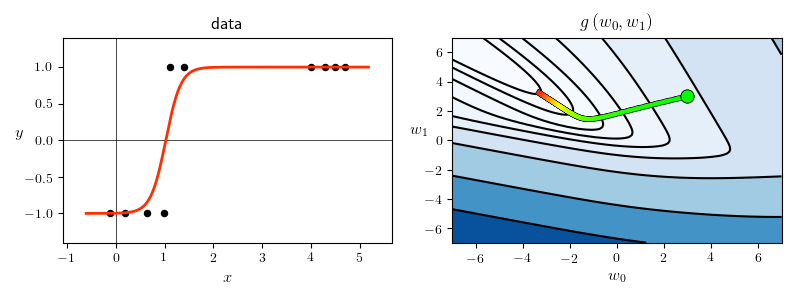
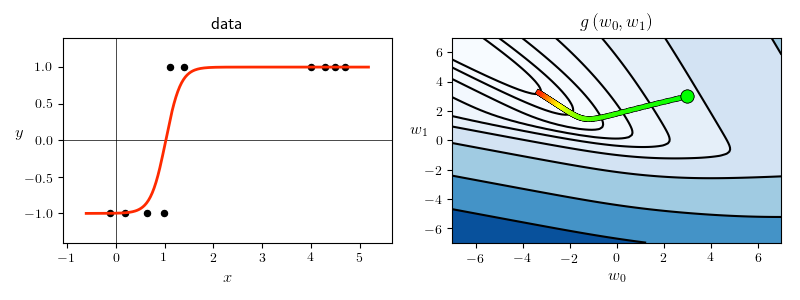
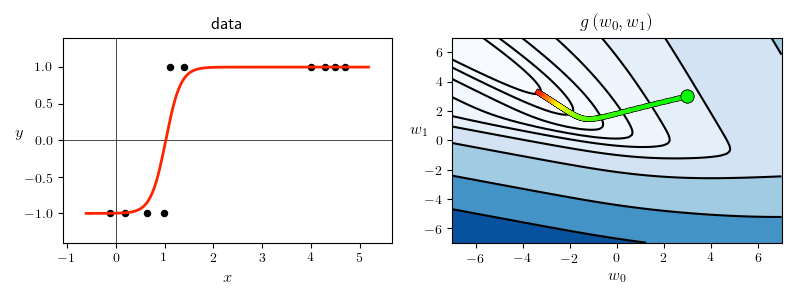
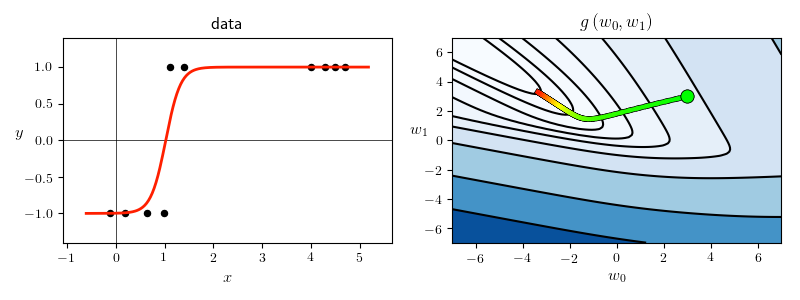
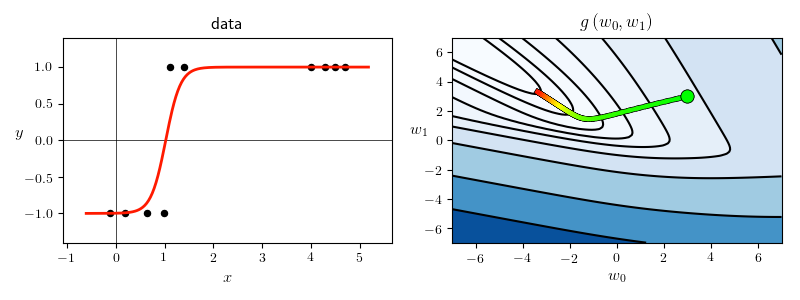
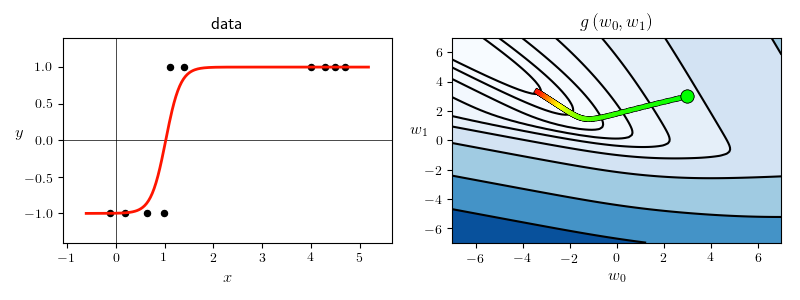
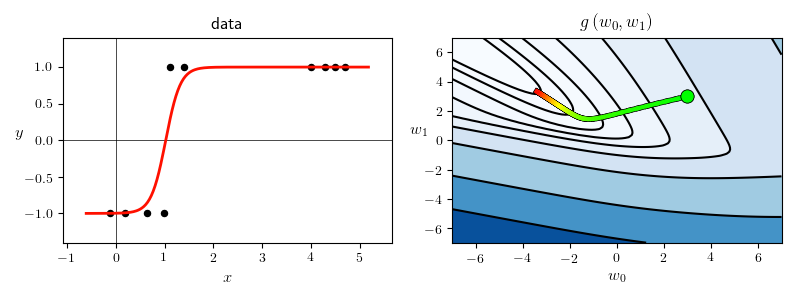
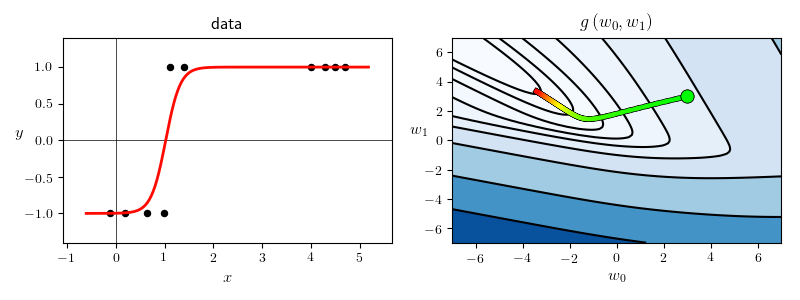
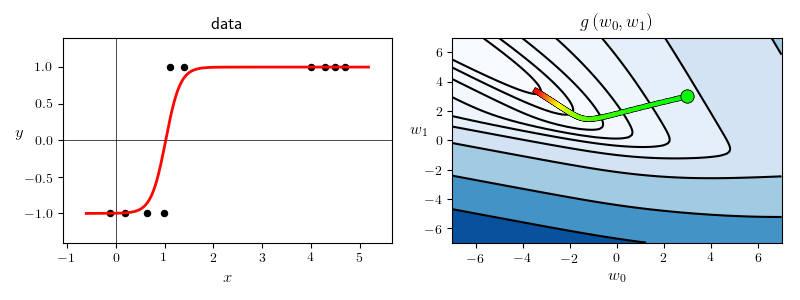
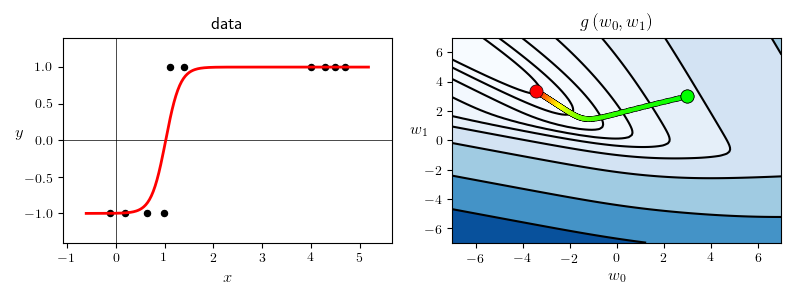

In [8]:
# create instance of logisic regression demo and load in data, cost function, and descent history
animator = superlearn.classification_2d_demos.Visualizer(data,softmax)

# animate descent process
animator.animate_run(weight_history,num_contours = 25,viewmax = 7)

Below we show the result of running gradient descent with the same initial point and fixed steplength parameter for $2000$ iterations, which results in a better fit.

In [21]:
# run gradient descent to minimize the softmax cost
g = softmax; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 2000; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

<IPython.core.display.Javascript object>


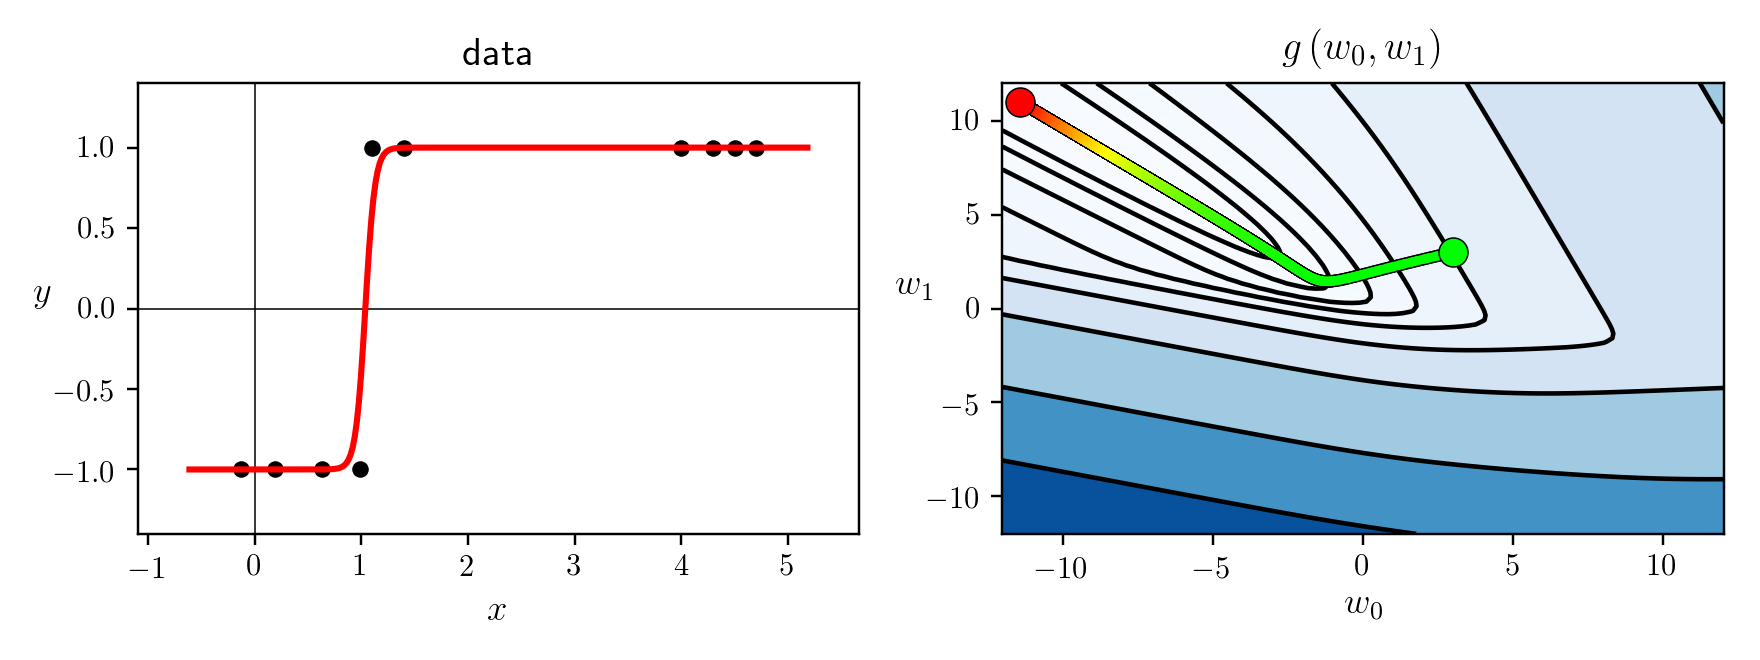

In [24]:
# create a static figure illustrating gradient descent steps 
animator.static_fig(weight_history,num_contours = 25,viewmax = 12)

As alternative to using an Automatic Differentiator, one can perform gradient descent to here by hand-computing the gradient of the softmax cost function.  Using the simple derivative rules outlined in Chapter 3 gradient can be computed as 

\begin{equation}
\nabla g\left(\mathbf{w}\right) = - \frac{1}{P}\sum_{p = 1}^P \frac{ e^{-\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,} }}{1 + e^{-\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}}\, y_p^{\,} \mathbf{x}_p^{\,}  
\end{equation}


Writing the gradient in this wah helps avoid numerical problems associated with using the exponential function on a modern computer. This is due to the exponential
'overflowing' with large exponents, e.g., $e^{1000}$, as these numbers are too large to store explicitly on the computer and so are
represented symbolically as $\infty$. This becomes a problem when evaluating $\frac{e^{1000}}{1+e^{1000}}$
which, although basically equal to the value $1$, is thought of by the computer to be a NaN (not a number) as it thinks $ $$\frac{e^{1000}}{1+e^{1000}}=\frac{\infty}{\infty}$
which is undefined. By writing each summand of the gradient such that it has an exponential in its denominator only, we avoid the problem
of dividing two overflowing exponentials.

## 9.1.2   'Noisy' datasets

Below we load in and plot a multi-input ($N = 2$) dataset that has 100 points, and whose two classes cannot be perfectly separated by any line (and consequently whose points cannot be perfectly fit using a tanh or even sign function).  In the left panel we show the data in three dimensions, and in the right panel we show the data from above in the 'separator' view.  

In [25]:
# load in dataset
data = np.loadtxt(datapath + '3d_classification_data_v0.csv',delimiter = ',')

<IPython.core.display.Javascript object>


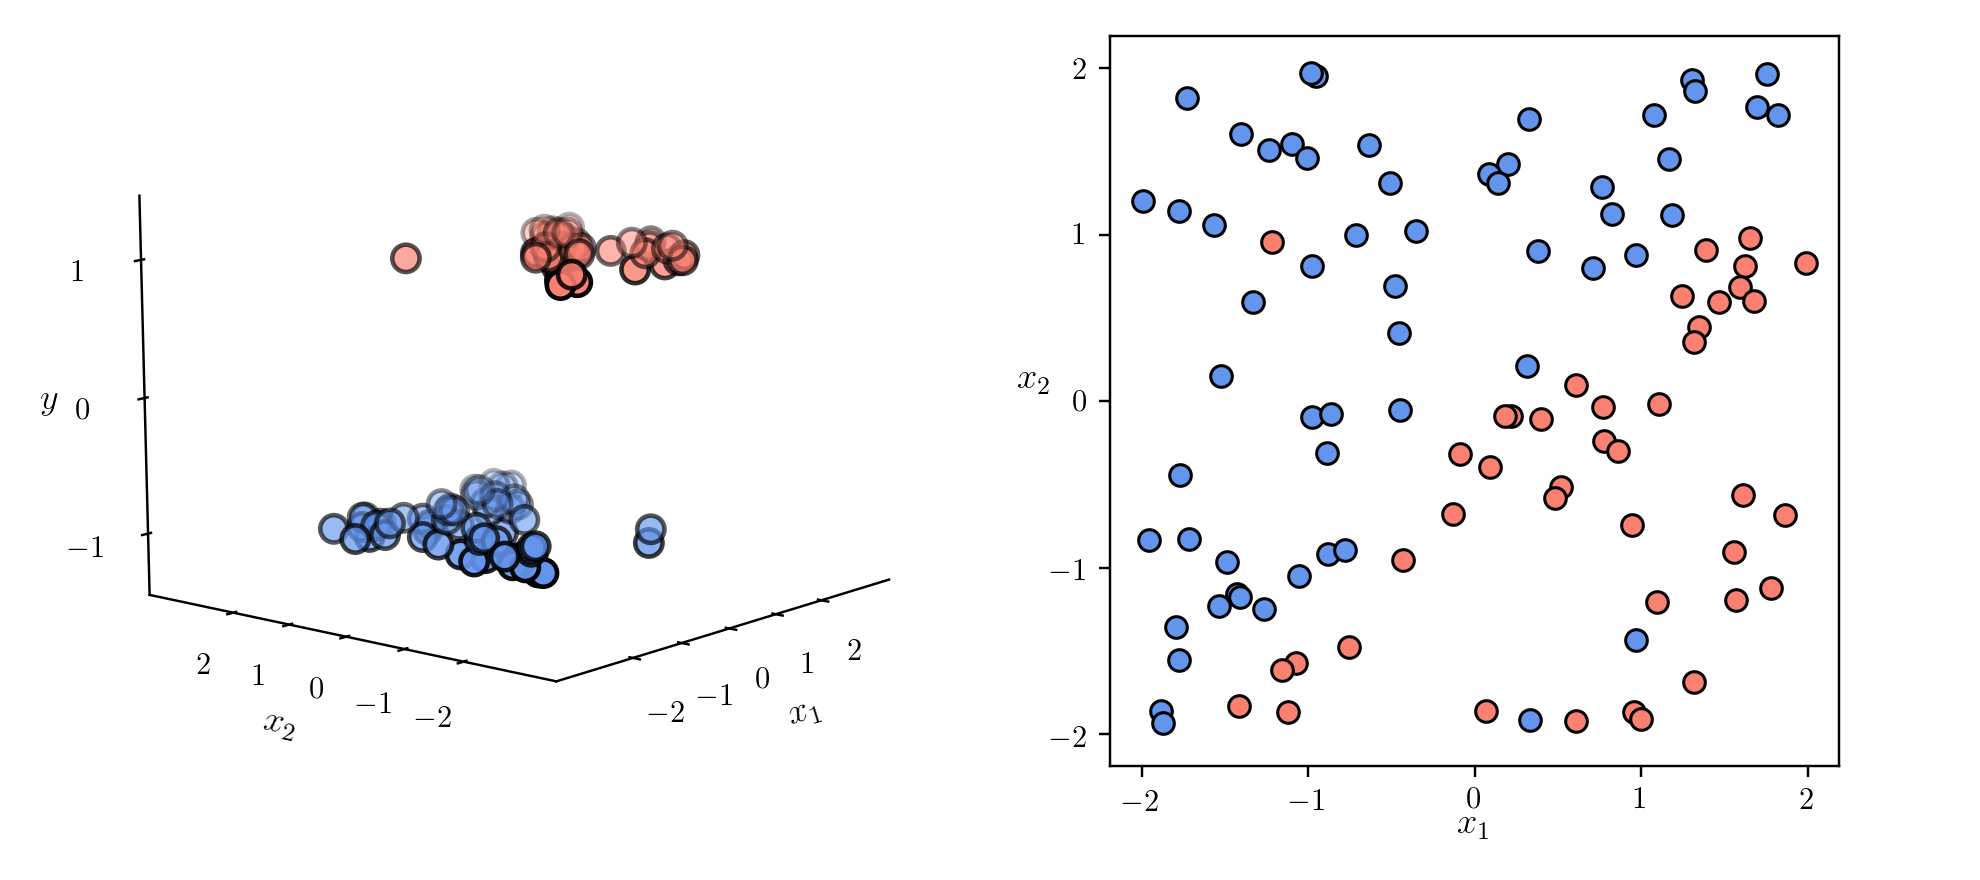

In [26]:
# create instance of linear regression demo, used below and in the next examples
demo = superlearn.classification_3d_demos.Visualizer(data)

# plot data
demo.plot_data(view = [15,-140])

As you can see, there are three points here (two blue points and one red points) that look like they are on 'the wrong side'. Other than these 'noisy' points the two classes look like they can be very well fit with our nonlinear regressor $\text{tanh}\left(w_0 + w_1x_1 + w_2x_2\right)$ in the left panel and at the same time separated by the line $w_0 + w_1x_1 + w_2x_2 = 0$ in the right panel - provided the weights are tuned properly.  Note: in the classification context a 'noisy' point is one that has an incorrect label.  Two class classification datasets typically have noise of this kind (just as we saw linear regression datasets have their own version of noise) and are not perfectly separable by a hyperplane.

> In the context of classification a 'noisy' point is one that has an incorrect label.  Two class classification datasets typically have noise of this kind (just as we saw linear regression datasets have their own version of noise) and are not perfectly separable by a hyperplane.

Even with the presence of noise we can still find the best parameters of a linear separator for a dataset like this by minimizing the softmax cost.  In the next ``Python`` cell we run $100$ steps of gradient descent with a random initialization and fixed steplenth $\alpha = 1$ to minimize the softmax cost on this dataset.

In [27]:
# get input/output pairs
x = data[:,:-1:].T
y = data[:,-1:] 

# tack a 1 onto the top of each input point
o = np.ones((1,np.shape(x)[1]));
x = np.concatenate((o,x),axis = 0)

In [29]:
# run gradient descent to minimize the softmax cost
g = softmax; w = np.random.randn(3,1); max_its = 100; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

To ensure this is a proper steplength value we check the cost function history plot below.

<IPython.core.display.Javascript object>


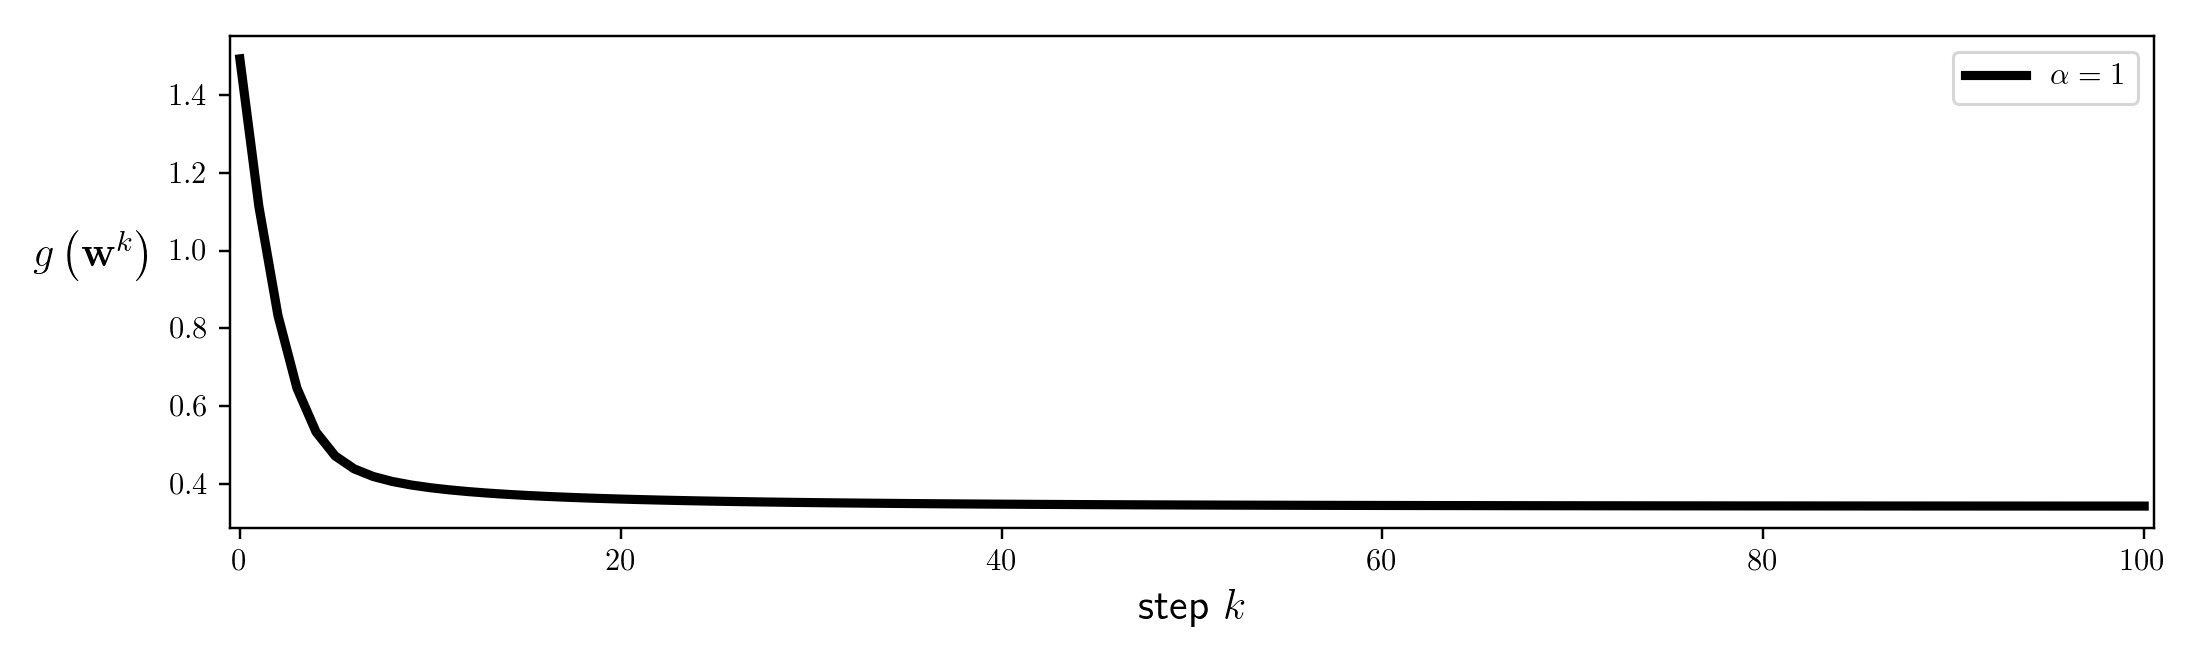

In [32]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

In the next ``Python`` cell we plot the trained logistic function. In the left panel the dataset is shown in three dimensions, along with tanh surface fit. We also show draw the separator or *decision boundary* in the plane $y = 0$.  This plane shows the linear separator (where the tanh surface is zero) and is colored to indicate which of the input are determined to be of class $-1$ (the region of space colored light blue) and $+1$ (the region of space colored light red). In the right panel we plot the data, separator, and classified regions colored in the same way from the 'separator' view.  Here we can easily identify three points that have been misclassified - our three 'on the wrong side' points (the two blue points in the red region, and the one red point in the blue region).

<IPython.core.display.Javascript object>


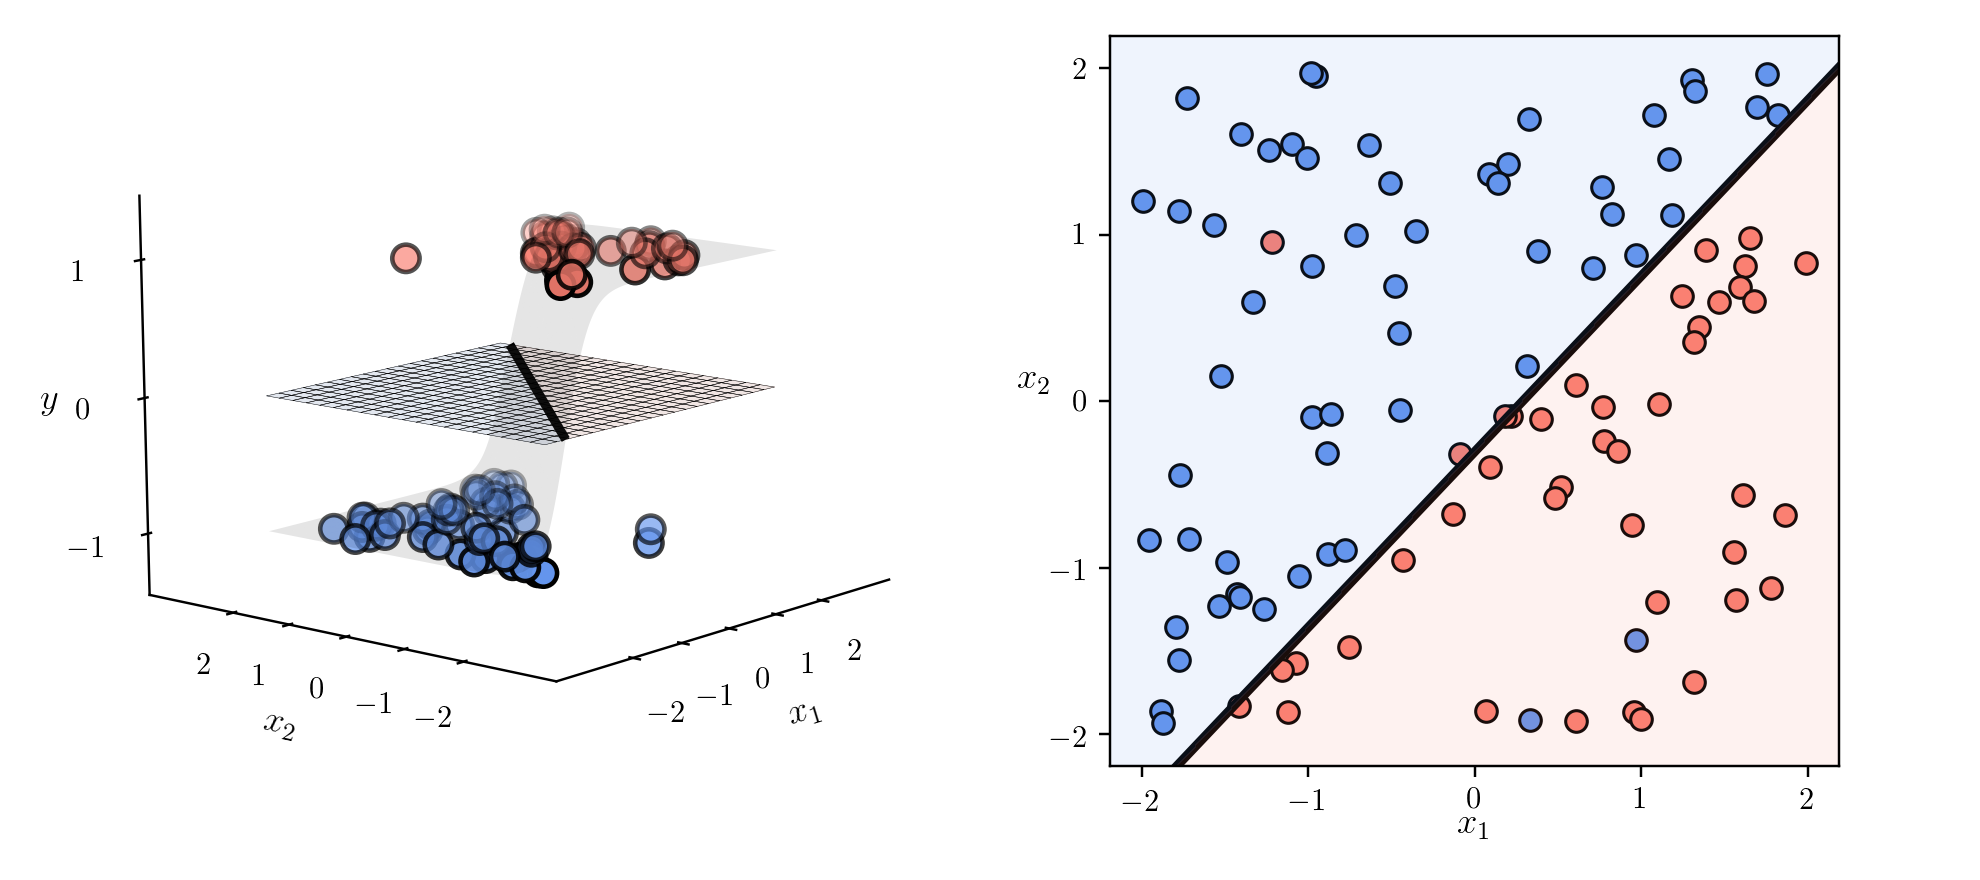

In [31]:
# create instance of 3d demos
demo = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo.static_fig(weight_history[-1],view = [15,-140])

## 9.1.3  Classification nomenclature and predictions

Regardless of the cost function we use to perform logistic regression - tanh Least Squares or softmax cost - once the weights have been tuned it is generally referred to as a *trained classifier*. 

> Regardless of the cost function we use to perform logistic regression - tanh Least Squares or softmax cost - once the weights have been tuned it is generally referred to as a *trained classifier*. 

Moreover, remember that the general goal with logistic regression is to learn a set of $N+1$ parameters - the optimal bias and weights in $\mathbf{w}^{\star}$ - so that the tanh function

\begin{equation}
f(\mathbf{x}) = \text{tanh}\left(\mathbf{x}^{T}\mathbf{w}^{\star}\right)
\end{equation}

fits the given dataset as best as possible.  This was as close as we could get to directly fitting the discontinuous step function  $\text{sign}\left(\mathbf{x}^{T}\mathbf{w}^{\star}\right)$ directly to the data.  

Importantly, this function (sometimes called a *decision function*) provides us with a learned linear *separator* or *decision boundary* where it intersects the plane $y = 0$.  This is where

\begin{equation}
\mathbf{x}^{T}\mathbf{w}^{\star} = 0
\end{equation}

This boundary is used to make predictions about every point in the space.  If a point $\mathbf{x}$ lies above it (i.e., if $\mathbf{x}^{T}\mathbf{w}^{\star} > 0$) then this point has a predicted label $+1$, likewise if the point lies below (i.e., if $\mathbf{x}^{T}\mathbf{w}^{\star} < 0$) the point has a predicted label $-1$.  If a point lies precisely on the boundary we cannot say which class it belongs to (in such cases one is typically assigned to the point at random).  Wrapping together these conditions we can say that to predict the label of an input point $\mathbf{x}_{\textrm{new}}$ we evaluate its weighted version using the sign function.  Denoting the predicted label $y_{\textrm{new}}$ we have

\begin{equation}
\text{sign}\,\left(\mathbf{x}_{\textrm{new}}^{T}\mathbf{w}^{\star}\right) = y_{\textrm{new}}
\end{equation}

> Once weights are properly tuned the *decision boundary* $\mathbf{x}^{T}\mathbf{w}^{\star} = 0$ provides a rule for determining which points - according to the classifier - belong to class $+1$ or $-1$.  This is done by  computing $\text{sign}\,\left(\mathbf{x}_{\textrm{new}}^{T}\mathbf{w}^{\star}\right)$.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_6_new.png' width="85%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 3:</strong> <em> Once a hyperplane has been learned to the current dataset with optimal parameters $w_0^{\star}$ and $\mathbf{w}^{\star}$, the label $y_{\textrm{new}}$ of a new point $\mathbf{x}_{\textrm{new}}$ can be predicted by simply checking which side of the boundary it lies on. In the illustration shown here $\mathbf{x}_{\textrm{new}}$ lies below the learned hyperplane, and as a result is given the label $y_{\textrm{new}}=\textrm{sign}\left(\mathbf{x}_{\textrm{new}}^{T}\mathbf{w}^{\star}\right)=-1$. </em>  </figcaption> 
</figure>

## 9.1.4  Counting misclassifications and the accuracy of a trained classifier

Notice how because $y_p \in \{\pm 1\}$ that the error produced by the counting cost for a single point either equals $0$ when the prediction matches the true label, or $4$ when a misclassification occurs

\begin{equation}
\left(\text{sign}\left(\mathbf{x}_p^T\mathbf{w}_{\,}^{\,} \right) - y_p \right)^2 = \begin{cases}
0 \,\,\,\, \text{if} \,\,\,\text{sign}\left(\mathbf{x}_p^T\mathbf{w}_{\,}^{\,} \right) =  y_p \\
4 \,\,\,\, \text{else} \\
\end{cases}
\end{equation}

Therefore to count the total number of misclassifications of a trained classifier we can simply evaluate the counting cost, dividing by $4$ as 

\begin{equation}
\text{number of misclassifications} = \frac{1}{4}\sum_{p=1}^P \left(\text{sign}\left(\mathbf{x}_p^T\mathbf{w}_{\,}^{\star} \right) - y_p \right)^2
\end{equation}

#### <span style="color:#a50e3e;">Example 9: </span> Comparing the softmax cost and the counting cost

Since the softmax cost is only our (convex) approximation to the counting cost it does not always track directly with the counting cost - and in particular the number of misclassifications - at each step of a descent run.  In this example we illustrate this using the second dataset from Example 6. The next Python cell below loads in this dataset and performs three runs of (unnormalized) gradient descent for 50 iterations each.  Each run has a random initial point but all three runs use the same steplength parameter $\alpha = 10^{-2}$.  

In the left panel the number of misclassifications is plotted per iteration of each run, while in the right panel the simultaneously measured value of the softmax cost function is shown.  Each run is color-coded to distinguish it from the other runs.

<IPython.core.display.Javascript object>


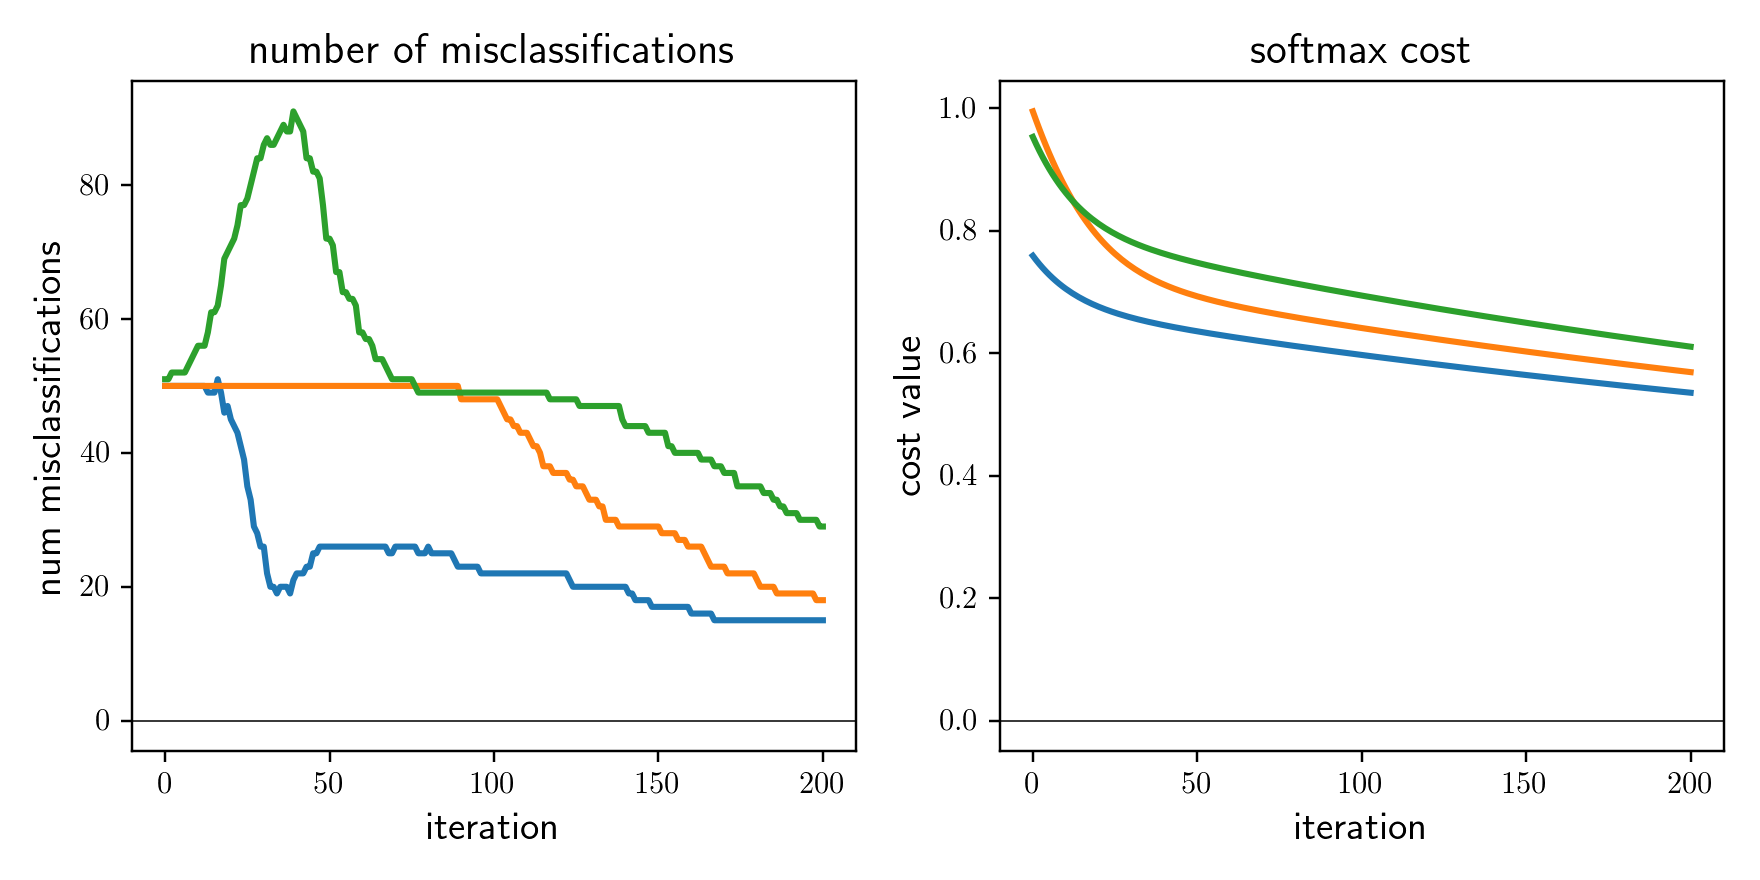

In [36]:
# load in dataset
data = np.loadtxt(datapath + '3d_classification_data_v2.csv',delimiter = ',')

# create instance of cost comparison demo
demo = superlearn.cost_comparisons.Visualizer(data)

# run 
demo.compare_to_counting(cost = 'softmax',max_its = 200,num_runs = 3,alpha = 10**(-1),algo = 'gradient_descent')

Comparing the left and right panels we can see that the number of misclassifications and softmax evaluations at each step of a gradient descent run do not perfectly track one another.  That is, it is not the case that just because the cost function value is decreasing that so too is the counting cost (number of misclassifications). Again, this occurs because our softmax cost is only an approximation of the true quantity we would like to minimize - the counting cost.

This has a useful practical implication: during optimization one should save the weight associated with the lowest *number of misclassifications* not the lowest cost value.

> During optimization of the softmax cost one should save the weight associated with the lowest *number of misclassifications* not the lowest cost value.

---

The simplest measure of how well a classifier has been trained on a set of $P$ training datapoints is its *accuracy*, which is the average number of points it classifies correctly.  We can compute this - for example - by taking the average evaluation of the *counting cost* 

\begin{equation}
\text{accuracy}= 1 - \frac{1}{4P}\sum_{p=1}^P \left(\text{sign}\left(\mathbf{x}_p^T\mathbf{w}_{\,}^{\star} \right) - y_p \right)^2
\end{equation}

which ranges from 0 (no points classified correctly) to 1 (all points classified correctly).  This is not always the best measure of a learned classifier's efficacy as, for instance, it fails to capture the classifier's quality on a highly *imbalanced* dataset. We will discuss this issue later.

## 9.1.5  Second order optimization methods, regularization, and the softmax cost

Since the softmax cost function is convex we can use a variety of local optimization methods to properly minimize it, as detailed in Chapters 5 - 7.  We can use e.g., Newton's method, any variety of coordinate descent methods, etc.,  In this subsection we discuss the use of Newton's method and a small but common adjustment made to cost functions like the softmax to adjust for the fact that Newton's method can sometimes work *too* well. 

In short there are instances  - most notably that of perfectly separable - where any logistic regression cost function will tend to have its global minimum out at infinity.  With the softmax cost function in particular, Newton's method will tend to take very large steps and - in such an instance - can thus quickly shoot off towards infinity.

#### <span style="color:#a50e3e;">Example 4: </span> Using Newton's method to perform logistic regression using the softmax cost

In applying Newton's method to minimize a cost function like the softmax we must be careful not to take too many steps, as it is possible that the global minimum technically lies at infinity (this is where the tanh function perfectly resembles the sign function), and taking too many large steps towards it can lead to numerical issues as weights becomes extremely large.  Here we examine a simple instance of this behavior using the single input dataset shown in the first subsection above.  

Newton's method can also be used to minimize the softmax cost in this instance, taking large steps moving towards infinity. In this example we illustrate the progress of 5 Newton steps beginning at the point $\mathbf{w} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$.  Within 5 steps we have reached a point providing a very good fit to the data.  If we take many more steps than shown here we will travel very far out in the input space of the function.

In [63]:
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1.csv')

# get input/output pairs
x = data[:,:-1:].T
y = data[:,-1:] 

# tack a 1 onto the top of each input point
o = np.ones((1,np.shape(x)[1]));
x = np.concatenate((o,x),axis = 0)

# run gradient descent to minimize the softmax cost
g = softmax; w = np.ones((2,1)); max_its = 5;
weight_history,cost_history = optimizers.newtons_method(g,max_its,w,epsilon = 10**(-7))

<IPython.core.display.Javascript object>


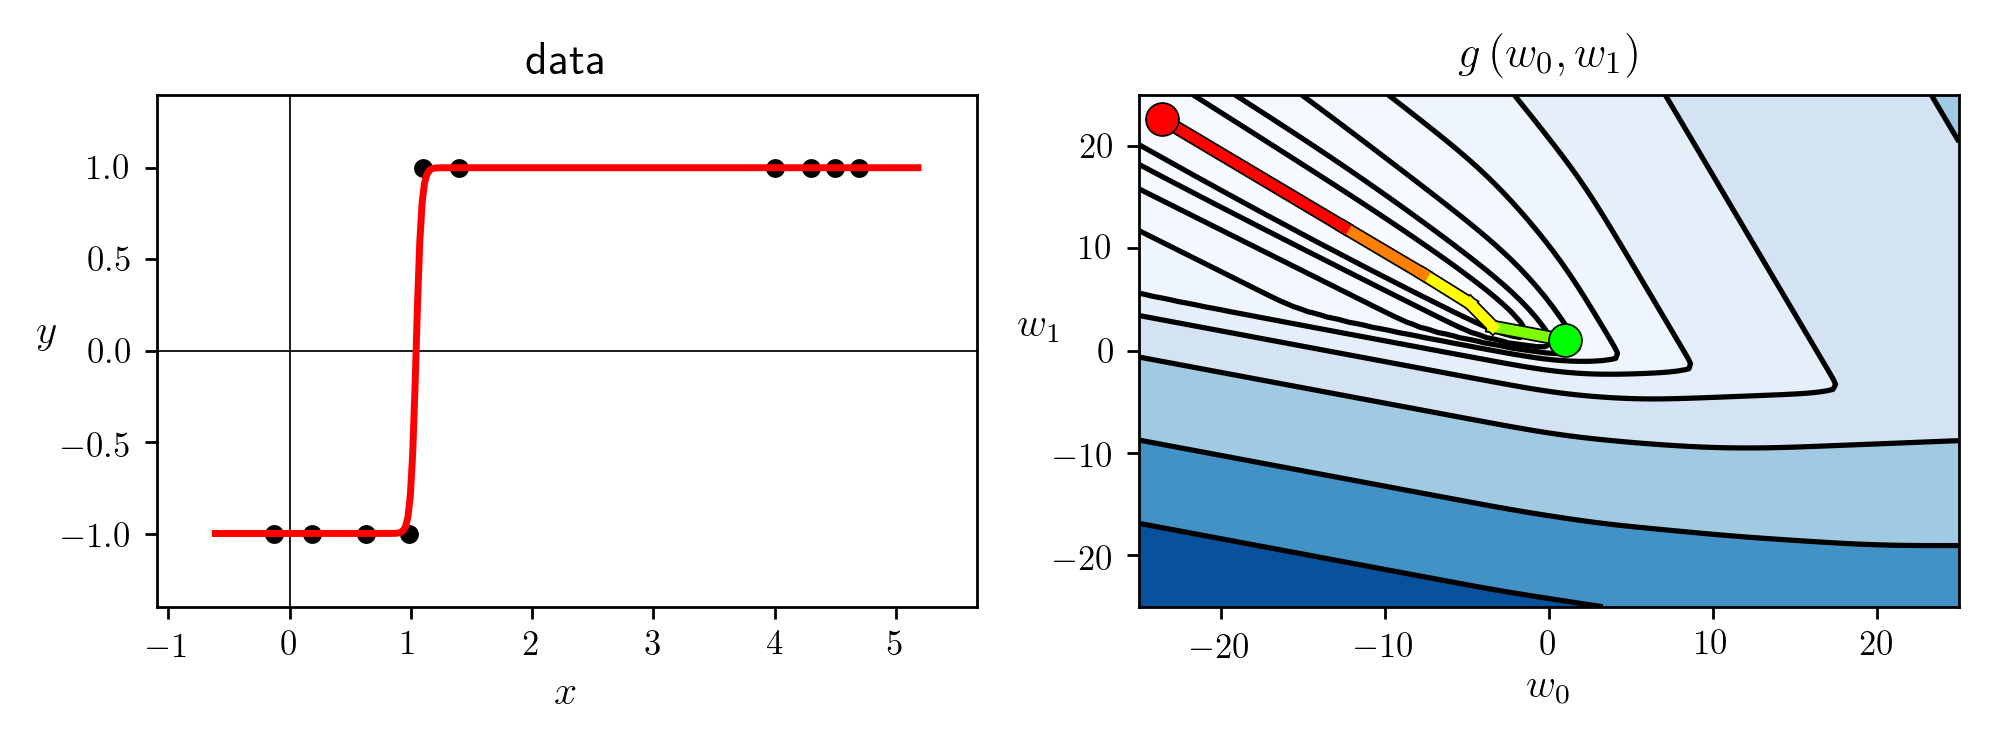

In [67]:
# create a static figure illustrating gradient descent steps 
animator.static_fig(weight_history,num_contours = 25,viewmax = 25)

Notice that if we simply flip one of the labels - making this dataset not perfectly linearly separable - the corresponding cost function does not have a global minimum out at infinity, as illustrated below.

<IPython.core.display.Javascript object>


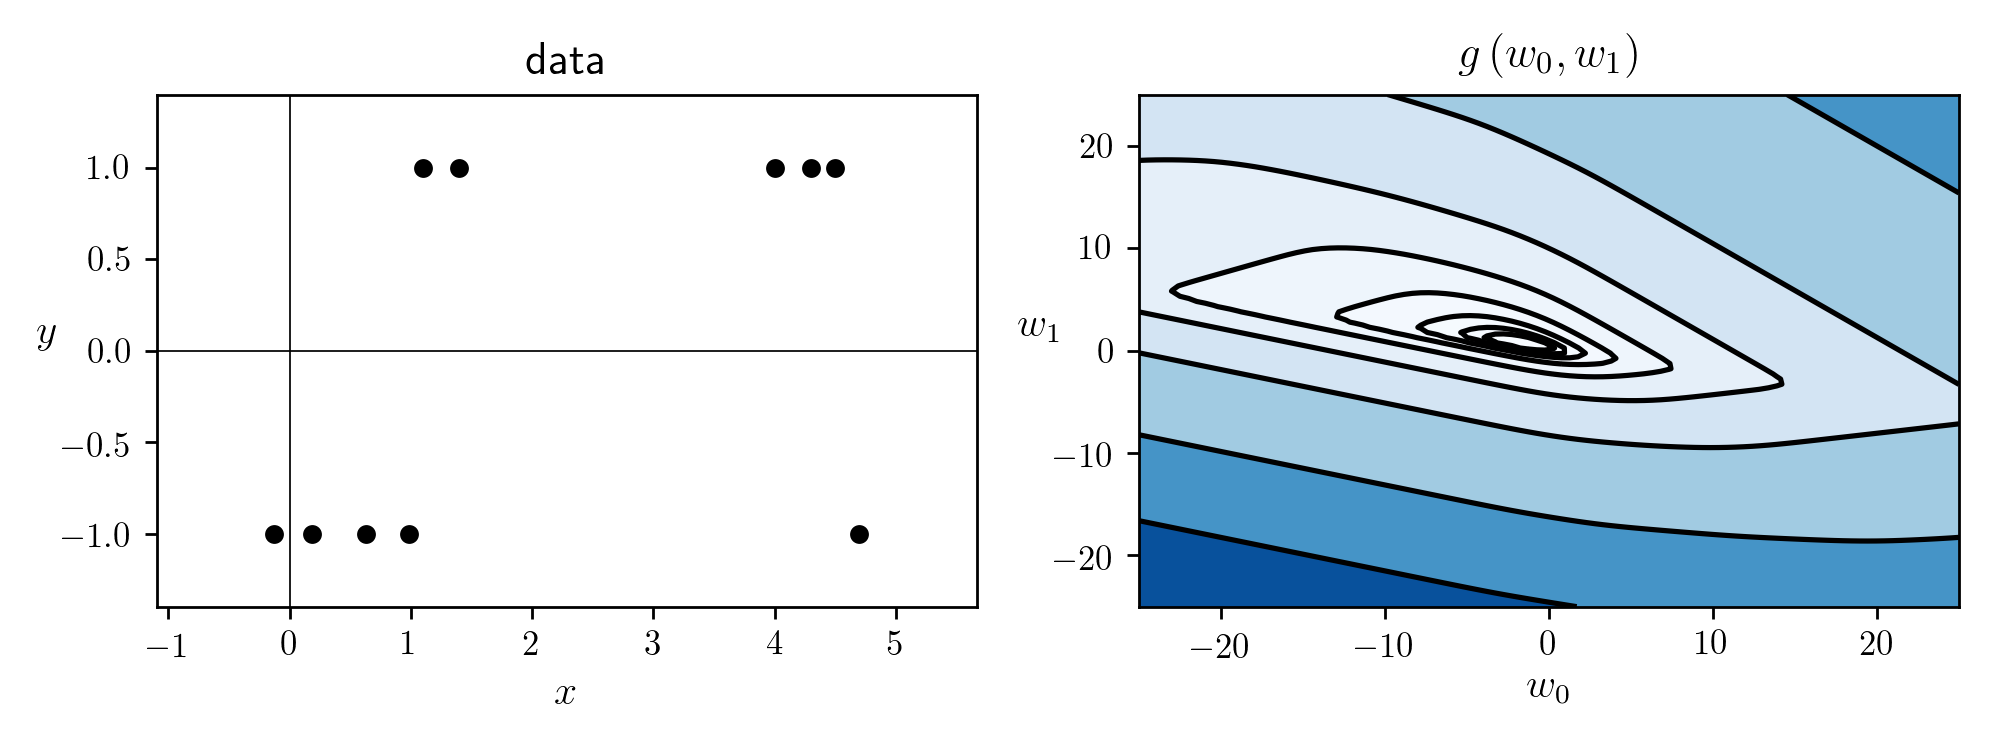

In [101]:
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1.csv')

# get input/output pairs
x = data[:,:-1:].T
y = data[:,-1:] 
y[-1] = -1
data = np.concatenate((x.T,y),axis = 1)
animator = superlearn.classification_2d_demos.Visualizer(data,softmax)

# create a static figure illustrating gradient descent steps 
animator.static_fig([],num_contours = 25,viewmax = 25)

As an alternative to using an automatic differentiator one can 'hard code' the gradient and Hessian for use with gradient descent and Newton's method.  Using the derivative rules from Chapter 3 we can easily hand-compute the gradient and Hessian as

\begin{equation}
\nabla g\left(\mathbf{w}\right) = - \frac{1}{P}\sum_{p = 1}^P \frac{ e^{-\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,} }}{1 + e^{-\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}}\, y_p^{\,} \mathbf{x}_p^{\,}  
\end{equation}

and 

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right)    \, \mathbf{x}_p^{\,}\mathbf{x}_p^T.
\end{equation}

---

Notice in the previous example how the learned weights keep growing large as we take more Newton steps. A general way to deal with this issue is to make sure the normal vector of the separating hyperplane has unit length, that is the final $N$ weights of the vector $\mathbf{w}$.  Denoting the final $N$ entries of our weight vector as $\mathbf{w}_{1:N}$ this gives us a constrained version of our problem

\begin{equation}
\begin{aligned}
\underset{\mathbf{w}}{\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\mathbf{x}_p^T \mathbf{w}^{\,}_{\,}}\right) \\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w}_{1:N} \right \Vert_2^2 = 1
\end{aligned}
\end{equation}

One way of solving this problem is via *projected gradient* -  that is by taking standard gradient descent steps and projecting the result onto the constraint.  However a more approach to solving this is to actually *relax* the problem, forming the *regularized* form of losgistic regression

\begin{equation}
\underset{\mathbf{w}}{\text{minimize}} \,\,\, \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\mathbf{x}_p^T \mathbf{w}^{\,}_{\,}}\right) + \lambda\, \left \Vert \mathbf{w}_{1:N} \right \Vert_2^2 \\
\end{equation}

where setting the regularization parameter $\lambda$ to a typically small positive value prevents the weights in the normal vector from exploding.

## 9.1.6 Coding for speed in ``Python``

In the previous Chapter we saw how coding up each cost function using as few explicit ``for`` loops, instead using ``numpy`` operations, as possible we could substantially speed up our cost functions (for evaluation, gradient computation, etc.,).  Here we can do the same.  In the next ``Python`` cell we re-implement the softmax cost using no explicit ``for`` loops leveraging the substantially faster ``numpy`` operations, and show how to do the same for the counting cost for counting the number of misclassifications provided by a given set of weights.

In [106]:
# the convex softmax cost function
def fast_softmax(w):
    cost = np.sum(np.log(1 + np.exp(-y*np.dot(x.T,w))))
    return cost/float(len(y))

# the counting cost function
def counting_cost(w):
    cost = np.sum((np.sign(np.dot(x.T,w)) - y)**2)
    return 0.25*cost 

## 9.1.7 Logistic regression from a probabilistic perspective

We saw in Section 8.2 that one could re-derive the Least Squares solution to linear regression via a maximum likelihood approach. The same can be done here for logistic regression, leading to formation of a cost function equivalent to the softmax cost, as we detail below.  Note here we will explicitly write the entire weight vector $\mathbf{w}$ in two components: the bias $w_0$ and the remainder of the weignts, our normal vector, as $\mathbf{w}$.

As with linear regression, we again make the assumption that the datapoints are statistically independent of each other, so that the likelihood can be written as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)
\end{equation}  

where ${\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)$ is the probability of the $p^{th}$ datapoint $\mathbf{x}_p$ having the label $y_p$ when the separating hyperplane is given by its defining parameters $w_0$ and $\mathbf{w}$. As pointed out previously in Subsection 1.1 where we chose $y_p \in\left\{−1,+1\right\}$, the class labels can take arbitrary (but distinct) values. With the probabilistic framework it is more convenient to replace $-1$ labels with $0$, so that $y_p \in\left\{0,1\right\}$ and we can write each product term in the likelihood compactly as


\begin{equation}
{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)={\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{y_p}\,{\cal P}\left(y=0\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{1-y_p}
\end{equation} 


Since $y_p$ takes only one of two values, we have that 

\begin{equation}
{\cal P}\left(y=0\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)= 1-{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)
\end{equation} 

giving the likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{y_p}\left[1-{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)\right]^{1-y_p}
\end{equation}

which is now written only in terms of ${\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)$.  

Before proposing a mathematical form for this probability and attempting to maximize the resulting likelihood, recall from our geometric discussion of logistic regression in previous subsections that the separating hyperplane $w_0+\mathbf{x}^T\mathbf{w}=0$ divides the input space of the problem into two half-spaces with the one characterized by $w_0+\mathbf{x}^T\mathbf{w}>0$ encompassing the $y=1$ class, and the one characterized by $w_0+\mathbf{x}^T\mathbf{w}<0$ encompassing the $y=0$ (previously $y=-1$) class.

Thinking probabilistically, this means that a point $\mathbf{x}_p$ belongs to class $y=1$ with probability 1 when $w_0+\mathbf{x}_p^T\mathbf{w}>0$, and to class $y=0$ with probability 1 when $w_0+\mathbf{x}_p^T\mathbf{w}<0$. Focusing only on the positive class, we can then write

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)=\begin{cases}
1 \,\,\,\,\,\text{if} \,\, w_0+\mathbf{x}_p^T\mathbf{w}>0 \\
0 \,\,\,\,\,\text{else} \\
\end{cases}
\end{equation} 

This probability expression can itself be thought of as a step function - with steps of $1$ and $0$ - jumping from one step to the other when $w_0+\mathbf{x}_p^T\mathbf{w}$ changes sign.    

Although seemingly a proper probability, the expression in equation (29) cannot be used for any dataset that is not perfectly separable by a hyperplane, in which case any (inevitable) misclassification will send the entire likelihood in equation (28) to zero. Using the logistic sigmoid function $\sigma(\cdot)$ as a strictly positive approximation to the 0/1 step function, we can resolve this issue by writing    

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)=\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)
\end{equation} 

which gives the likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)^{y_p}\left[1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right]^{1-y_p}
\end{equation}

and the corresponding negative log-likelihood as 


\begin{equation}
g\left(w_0,\mathbf{w}\right)=-\sum_{p=1}^{P}y_p\,\text{log}\,\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)+\left(1-y_p\right)\text{log}\,\left(1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right)
\end{equation}  

The cost function in equation (32) is typically referred to as *the cross-entropy cost* which is equivalent to the softmax cost when using $\pm1$ labels. To see why this is the case, notice that when $y_p=0$ the cross-entropy term for $\mathbf{x}_p$ reduces to 

\begin{equation}
-\text{log}\,\left(1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right)
\end{equation}  

which is identical to the softmax term for $\mathbf{x}_p$ 

\begin{equation}
\text{log}\,\left(1+e^{-y_p\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)}\right)
\end{equation}  


when $y_p=-1$, using the definition of the sigmoid function as

\begin{equation}
\sigma\left(s\right)=\frac{1}{1+e^{-s}}
\end{equation}  



Similarly one can show that when $y_p =1$ with both costs, the cross-entropy term 


\begin{equation}
-\text{log}\,\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)
\end{equation}  

and the softmax term 

\begin{equation}
\text{log}\,\left(1+e^{-y_p\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)}\right)
\end{equation}  



are again the same, proving the two cost functions are indeed equivalent. 

> The maximum likelihood approach to logistic regression leads to the cross-entropy loss, which is equivalent to the softmax cost (after simple reassignment of class labels).   

The probabilistic perspective on logistic regression, by design, enables us to assign a probability score to each point in our dataset once the optimal hyperplane parameters $w_0^{\star}$ and $\mathbf{w}^{\star}$ are learned. Specifically, the probability of the point $\mathbf{x}_p$ belonging to class $y=1$ is given by

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0^{\star},\mathbf{w}^{\star}\right)=\sigma\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}\right)
\end{equation} 

This probability score can be interpreted as how 'confident' our classifier is in predicting a label of $y=1$ for $\mathbf{x}_p$. If $w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}>0$, the larger this evaluation gets the closer the probability gets to a value of 1, and hence the more confident we are of xp belonging to class y=1. On the other hand, when $w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}<0$ the probability of $y=1$ falls below $50\%$ and as the evaluation gets smaller the probability approaches zero, while at the same time its complement - the probability of $y=0$ - gets closer to 1.       

This notion of confidence - which can be particularly useful when dealing with new datapoints whose labels are not known a priori - is strongly connected to the geometric notion of distance from the separating hyperplane. The figure below shows two datapoints $\mathbf{x}_p$ and $\mathbf{x}_q$, both lying in the positive half-space created by the hyperplane $w_0+\mathbf{x}^T\mathbf{w}=0$, whose distances from the hyperplane can be calculated - using simple algebra - as $\frac{w_{0}+\mathbf{x}_{p}^{T}\mathbf{w}}{\left\Vert \mathbf{w}\right\Vert _{2}}$ and $\frac{w_{0}+\mathbf{x}_{q}^{T}\mathbf{w}}{\left\Vert \mathbf{w}\right\Vert _{2}}$, respectively.      

<figure>
  <img src= '../../mlrefined_images/superlearn_images/distance_to_boundary.png' width="70%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 4:</strong> <em> Visual representation of the distance to the hyperplane $w_0+\mathbf{x}^T\mathbf{w}=0$, from two points $\mathbf{x}_p$ and $\mathbf{x}_q$ lying above it. </em>  </figcaption> 
</figure>

Ignoring the common denominator $\left\Vert \mathbf{w}\right\Vert _{2}$, the distance from a point to the hyperplane is proportional to its evaluation using the hyperplane, which is then mapped to a number between 0 and 1 via the sigmoid function, producing a valid probability score.  

> The notion of class probability is closely connected to the geometric notion of distance to the decision boundary. The farther a point is from the decision boundary the more confident the classier becomes about its predicted label. Conversely, as we get closer to the boundary, the classifier loses 'confidence' and the probability scores for each class get closer in value. In the most extreme case where the point lies precisely in the separating hyperplane, the distance is zero, giving a 50-50 probability of the point belonging to either class.

## 9.1.7 Appendix

### Proof that the softmax cost function is convex

To show that the softmax cost function is convex we can use the second order definition of convexity, by which we must show that the eigenvalues of the softmax's Hessian matrix are all always nonnegative. Studying the Hessian of the softmax - which was defined algebraically in Example 4 above - we have 

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right)    \, \mathbf{x}_p^{\,}\mathbf{x}_p^T.
\end{equation}

We know that the smallest eigenvalue of any square symmetric matrix is given as the minimum of the *Rayleigh quotient* (as detailed Section 6.1), i.e., the smallest value taken by 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}
\end{equation}

for any unit-length vector $\mathbf{z}$ and any possible weight vector $\mathbf{w}$. Substituting in the particular form of the Hessian here, denoting $\sigma_p = \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right) $ for each $p$ for 
short, we have

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}=
\mathbf{z}^T \left(\frac{1}{P} \sum_{p=1}^{P}\sigma_p \mathbf{x}_p^{\,}\mathbf{x}_p^T\right) \mathbf{z}^{\,} =  \frac{1}{P}\sum_{p=1}^{P}\sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)\left( \mathbf{x}_{p}^T \mathbf{z}^{\,} \right) = \frac{1}{P}\sum_{p=1}^{P} \sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2
\end{equation}

Since it is always the case that $\left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2 \geq 0$ and $\sigma_p \geq 0$, it follows that the smallest value the above can take is $0$, meaning that this is the smallest possible eigenvalue of the softmax cost's Hessian.  Since this is the case, the softmax cost must be convex.

### Computation of the Lipschitz constant 

Building on the analysis above showing that the softmax cost is convex, we can likewise compute its largest possible eigenvalue by noting that the largest value $\sigma_k$ (defined previously) can take is $\frac{1}{4}$

\begin{equation}
\sigma_k \leq \frac{1}{4}
\end{equation}

Thus the largest value the *Rayleigh quotient* can take is bounded above for any $\mathbf{z}$ as 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,} \leq \frac{1}{4P}\mathbf{z}^T \left(\sum_{p=1}^{P}\mathbf{x}_p^{\,}\mathbf{x}_p^T  \right) \mathbf{z}^{\,}
\end{equation}

Since the maximum value $\mathbf{z}^T \left(\sum_{p=1}^{P}\mathbf{x}_p^{\,}\mathbf{x}_p^T  \right) \mathbf{z}^{\,}$ can take is the maximum eigenvalue of the matrix $\sum_{p=1}^{P}\mathbf{x}_p^{\,}\mathbf{x}_p^T$, thus a Lipschitz constant for the softmax cost is given as

\begin{equation}
L = \frac{1}{4P}\left\Vert \sum_{p=1}^{P}{\mathbf{x}}_p^{\,}{\mathbf{x}}_p^T \right\Vert_2^2
\end{equation}